In [1]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


In [3]:
def label_normaliser(label):
    total = sum(label)
    if total == 0:
        return [0 for _ in label]  # Return an array of zeros if total is zero
    else:
        return [value / total for value in label]
    

def normalize_spectrum_by_area(spectrum):
    """
    Normalize a 1D XPS spectrum by area (integral under the curve).
    
    Args:
        spectrum (torch.Tensor or np.ndarray): The input spectrum to normalize.
    
    Returns:
        np.ndarray: Normalized spectrum with area under the curve equal to 1.
    """
    # Convert to NumPy array if it's a PyTorch tensor
    if isinstance(spectrum, torch.Tensor):
        spectrum = spectrum.cpu().detach().numpy()  # Ensure it's on CPU and convert to NumPy

    # Compute the area under the spectrum (sum of intensities)
    area = np.sum(spectrum)

    # Avoid division by zero (if area is zero, return the original spectrum)
    if area == 0:
        return spectrum

    # Normalize the spectrum
    return spectrum / area
    
def label_converter(label, FG_list):
    '''
    Converts the encoded label lists into a readable format

    '''
    fg_counts = []
    fg_count = "" 

    for i, e in enumerate(label):
        if pd.isna(e):
            e = 0
        if e != 0.0:
            fg_count = f'{e:.2f}  {FG_list[i]}'
            fg_counts.append(fg_count)

    return fg_counts

def create_uniform_energy_grid(start_energy, end_energy, increment=0.1):
    """
    Create a uniform energy grid with a fixed increment.
    
    Args:
        start_energy: Starting energy value.
        end_energy: Ending energy value.
        increment: Energy increment (default is 0.1 eV).
    
    Returns:
        energy_range: Uniform energy grid as a NumPy array.
    """
    return np.arange(start_energy, end_energy + increment, increment)

def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

data_path = Path("../data/experimental_data")
CEL_FG_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx')
FG_list = get_label_dict(CEL_FG_path)
FG_list.append('alkane')

start_energy = 40
end_energy = 700
BE_values = create_uniform_energy_grid(start_energy, end_energy)

In [4]:
test_spectra_dir = Path('../data/test_data_final/test_spectra/test_spectra_hard_final.npy')
test_labels_dir = Path('../data/test_data_final/test_labels/test_labels_hard_final.npy')
# '../data/test_data_final/test_labels/test_labels_hard_final.npy'

# Load the spectra and labels
test_spectra = np.load(test_spectra_dir)
unormalised_labels = np.load(test_labels_dir)
test_labels = np.array([label_normaliser(i) for i in unormalised_labels])


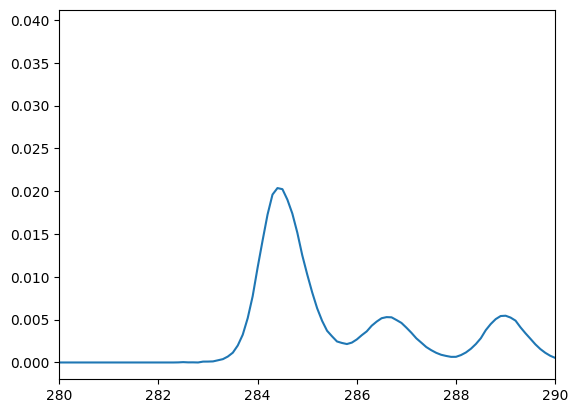

['0.11  ether (aliphatic)', '0.71  ester (aliphatic)', '0.07  siloxane', '0.11  alkane']


In [5]:
i = 11
plt.plot(BE_values, test_spectra[i])
plt.xlim(280,290)
plt.show()

l = label_converter(test_labels[i],FG_list)
print(l)



In [6]:
class FixedCVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super().__init__()
        
        # Enhanced encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 2 * latent_dim)
        )
        
        # Constrained decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.Dropout(0.3),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, input_dim),
            nn.Softplus()  # Ensure positive output
        )

    def encode(self, x, c):
        x = torch.cat([x, c], 1)
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        logvar = torch.clamp(logvar, max=0)  # Prevent exp(logvar) > 1
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar).clamp(max=1.0)  # Limit variance
        return mu + std * torch.randn_like(std)

    def decode(self, z, c):
        z = torch.cat([z, c], 1)
        return self.decoder(z)
     
    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var
    

In [7]:

class RevisedCVAE(nn.Module):
    """
    Revised CVAE with LayerNorm, increased capacity, linear output,
    and no variance clamping. Designed for large datasets and high-dim input.
    """
    def __init__(self, input_dim, latent_dim, cond_dim,
                 hidden_dim_1=1024, # Increased width
                 hidden_dim_2=512,  # Increased width
                 dropout_rate=0.2): # Reduced dropout
        super().__init__()
        self.latent_dim = latent_dim

        # === Encoder ===
        # Input: Concatenated x and c
        encoder_layers = []
        # Layer 1
        encoder_layers.extend([
            nn.Linear(input_dim + cond_dim, hidden_dim_1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(hidden_dim_1), # LayerNorm after activation
            nn.Dropout(dropout_rate)
        ])
        # Layer 2
        encoder_layers.extend([
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(hidden_dim_2), # LayerNorm after activation
            nn.Dropout(dropout_rate)
        ])
        # Output Layer (to mu and logvar)
        encoder_layers.append(nn.Linear(hidden_dim_2, 2 * latent_dim))

        self.encoder = nn.Sequential(*encoder_layers)

        # === Decoder ===
        # Input: Concatenated z and c
        decoder_layers = []
        # Layer 1
        decoder_layers.extend([
            nn.Linear(latent_dim + cond_dim, hidden_dim_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(hidden_dim_2), # LayerNorm after activation
            nn.Dropout(dropout_rate)
        ])
        # Layer 2
        decoder_layers.extend([
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(hidden_dim_1), # LayerNorm after activation
            nn.Dropout(dropout_rate)
        ])
        # Output Layer (to reconstruction)
        decoder_layers.append(nn.Linear(hidden_dim_1, input_dim))
        # decoder_layers.append(nn.Identity()) # Explicitly linear output (optional)
        # Removed nn.Softplus()

        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x, c):
        # Concatenate input spectrum and condition
        combined_input = torch.cat([x, c], dim=1)
        # Pass through encoder
        h = self.encoder(combined_input)
        # Split into mu and logvar
        mu, logvar = torch.chunk(h, 2, dim=1)
        # NO logvar clamping - let KLD regulate
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        # NO std clamping - let KLD regulate
        return mu + eps * std

    def decode(self, z, c):
        # Concatenate latent code and condition
        combined_input = torch.cat([z, c], dim=1)
        # Pass through decoder
        reconstruction = self.decoder(combined_input)
        return reconstruction

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, c)
        return recon_x, mu, log_var

In [8]:
import torch
import torch.nn as nn
import numpy as np # Keep if needed elsewhere

class CVAE_Option1(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super().__init__()
        self.latent_dim = latent_dim # Store for potential use later
        self.input_dim = input_dim
        self.cond_dim = cond_dim

        # --- Encoder (Keep as is) ---
        self.encoder_layers = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.BatchNorm1d(512), # Note: Still using BN here in encoder
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            # Output layer calculated separately below
        )
        # Linear layer to produce mu and log_var
        self.fc_mu_logvar = nn.Linear(256, 2 * latent_dim)

        # --- More Powerful Decoder ---
        # Increased depth and consistent LayerNorm
        self.decoder = nn.Sequential(
            # Input: latent_dim + cond_dim
            nn.Linear(latent_dim + cond_dim, 512), # Start wider
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 512), # First hidden layer
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 512), # Second hidden layer (added depth)
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            # No dropout right before output usually

            nn.Linear(512, input_dim), # Output layer
            nn.Softplus()  # Ensure positive output (keep if your data is non-negative)
        )

    def encode(self, x, c):
        combined_input = torch.cat([x, c], 1)
        hidden = self.encoder_layers(combined_input)
        mu_logvar = self.fc_mu_logvar(hidden)
        mu, logvar = torch.chunk(mu_logvar, 2, dim=1)
        # --- Consider revisiting this clamp ---
        # Clamping might prevent variance from properly reaching 1 if logvar naturally wants to be > 0
        # logvar = torch.clamp(logvar, max=0)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # --- Consider revisiting this clamp ---
        # std = std.clamp(max=1.0) # This might also interfere with KL calculation/target
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        combined_input = torch.cat([z, c], 1)
        return self.decoder(combined_input)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, c)
        return recon_x, mu, log_var

In [9]:
import torch
import torch.nn as nn
import numpy as np # Keep if needed elsewhere

class CVAE_Option2(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.cond_dim = cond_dim

        # --- Encoder (Keep as is) ---
        self.encoder_layers = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
        )
        self.fc_mu_logvar = nn.Linear(256, 2 * latent_dim)

        # --- Wider Decoder ---
        self.decoder = nn.Sequential(
            # Input: latent_dim + cond_dim
            nn.Linear(latent_dim + cond_dim, 512), # Wider start
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 1024), # Wider hidden layer 1
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512), # Wider hidden layer 2 (could also be 1024)
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, input_dim), # Output layer
            nn.Softplus()
        )

    # --- encode, reparameterize, decode, forward methods (same as Option 1) ---
    def encode(self, x, c):
        combined_input = torch.cat([x, c], 1)
        hidden = self.encoder_layers(combined_input)
        mu_logvar = self.fc_mu_logvar(hidden)
        mu, logvar = torch.chunk(mu_logvar, 2, dim=1)
        # logvar = torch.clamp(logvar, max=0) # Optional clamp
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # std = std.clamp(max=1.0) # Optional clamp
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        combined_input = torch.cat([z, c], 1)
        return self.decoder(combined_input)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, c)
        return recon_x, mu, log_var

In [10]:
def recon_loss(recon_x, x):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    return MSE

In [11]:
input_dim = 6601
cond_dim = 40
latent_dim = 1

prior_std = 0.1
prior_epsilon = prior_std**2


model_name =  'CVAE1d(alkane).pth' 
#newCVAE1d.pth
# "best_CVAE_12d.pth" - pretty good
# "CVAE_2d.pth" - bad
# "CVAE_3d_goat.pth" - bad


local_models_dir = "/home/issa/new_project_clone/local_models/"

model_path = os.path.join(local_models_dir , model_name)

# Initialize model
model = CVAE_Option2(input_dim, latent_dim, cond_dim).to(device)
#model = FixedCVAE(input_dim, latent_dim, cond_dim).to(device)
# Load the trained model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


CVAE_Option2(
  (encoder_layers): Sequential(
    (0): Linear(in_features=6641, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu_logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=41, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bi

In [12]:
def normalize_spectra_by_area(spectrum):
    """
    Normalize a 1D XPS spectrum by area (integral under the curve).
    
    Args:
        spectrum (torch.Tensor or np.ndarray): The input spectrum to normalize.
    
    Returns:
        np.ndarray: Normalized spectrum with area under the curve equal to 1.
    """
    # Convert to NumPy array if it's a PyTorch tensor
    if isinstance(spectrum, torch.Tensor):
        spectrum = spectrum.cpu().detach().numpy()  # Ensure it's on CPU and convert to NumPy

    # Compute the area under the spectrum (sum of intensities)
    area = np.sum(spectrum)

    # Avoid division by zero (if area is zero, return the original spectrum)
    if area == 0:
        return spectrum

    # Normalize the spectrum
    return spectrum / area

tensor([0.2434, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1348, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6217])


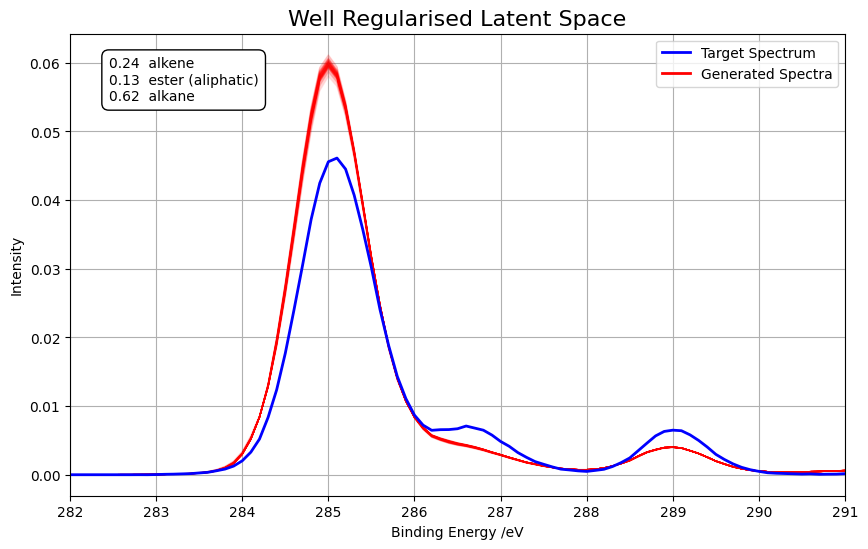

In [13]:
index = 6


example_spectra_tensor  = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])
print(example_label_tensor)

# Get the specific example
with torch.no_grad():
    X_example = example_spectra_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    y_example = example_label_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

plt.figure(figsize=(10, 6))
num_trials = 100
 
for trial in range(num_trials):
    # Generate latent vector
    z = torch.randn(1, latent_dim).to(device) # Sample a random latent vector


    # Decode the latent vector to generate spectra
    with torch.no_grad():  # No need to track gradients
        generated_spectra = model.decode(z, y_example)


    # Move data back to CPU for plotting
    X_example = X_example.cpu().squeeze()  # Remove batch dimension
    y_example_list = y_example.cpu().squeeze().tolist()
    generated_spectra = generated_spectra.cpu().squeeze()
    generated_spectra[generated_spectra < 0] = 0


    #normalised_generated_spectra = normalize_spectra_by_area(np.array(generated_spectra)).squeeze()
    plt.plot(BE_values, normalize_spectra_by_area(generated_spectra), color="red", linestyle="-", linewidth=1, alpha=0.1)
    #plt.plot(normalised_generated_spectra, color="green", linestyle="-", linewidth=2, alpha=0.7)


plt.plot(BE_values, X_example, color="blue", linewidth=2, label="Target Spectrum")
plt.plot([], [], color="red", linestyle="-", linewidth=2, label="Generated Spectra")
label_text = label_converter(y_example_list, FG_list)


if not label_text:
    box = 'no functional groups'
else:
    box = "\n".join(label_text)


plt.text(0.05, 0.95, box, 
         ha='left', va='top',  # Horizontal and vertical alignment
         fontsize=10, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
         transform=plt.gca().transAxes
         )  # Place box in top right


#plt.title(f"Original vs Generated Spectrum (Example {index})")
plt.title(f"Well Regularised Latent Space", fontsize = 16)
plt.ylabel("Relative Intensity")
plt.grid(True)
plt.legend()
plt.xlabel("Binding Energy /eV")
plt.ylabel("Intensity")
# Set limits using the axes object
plt.xlim(282,291)
plt.ylim() 

plt.show()


tensor([0.2434, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1348, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6217])


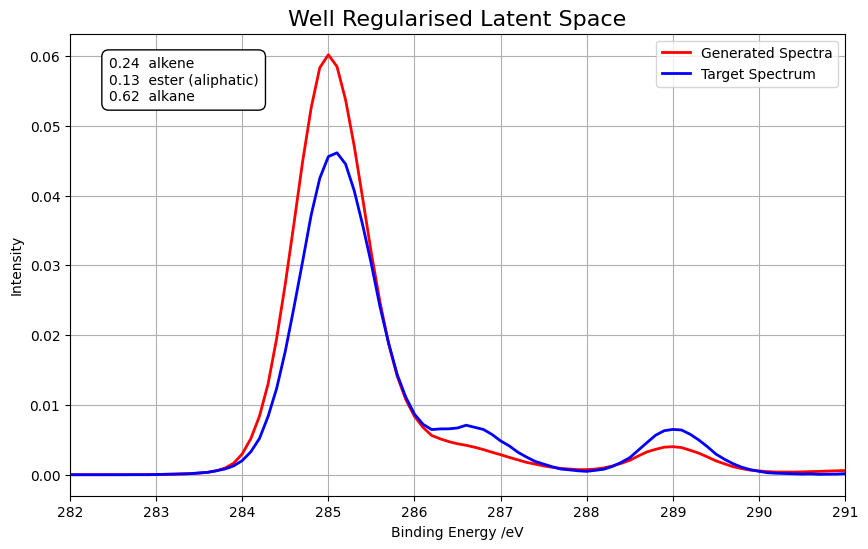

In [14]:
index = 6


example_spectra_tensor  = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])
print(example_label_tensor)

# Get the specific example
with torch.no_grad():
    X_example = example_spectra_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    y_example = example_label_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

plt.figure(figsize=(10, 6))

# Generate latent vector
z = torch.randn(1, latent_dim).to(device) # Sample a random latent vector


# Decode the latent vector to generate spectra
with torch.no_grad():  # No need to track gradients
    generated_spectra = model.decode(z, y_example)


# Move data back to CPU for plotting
X_example = X_example.cpu().squeeze()  # Remove batch dimension
y_example_list = y_example.cpu().squeeze().tolist()
generated_spectra = generated_spectra.cpu().squeeze()
generated_spectra[generated_spectra < 0] = 0


#normalised_generated_spectra = normalize_spectra_by_area(np.array(generated_spectra)).squeeze()
plt.plot(BE_values, normalize_spectra_by_area(generated_spectra), color="red", linestyle="-", linewidth=2, label="Generated Spectra")
#plt.plot(normalised_generated_spectra, color="green", linestyle="-", linewidth=2, alpha=0.7)

plt.plot(BE_values, X_example, color="blue", linewidth=2, label="Target Spectrum")
label_text = label_converter(y_example_list, FG_list)


if not label_text:
    box = 'no functional groups'
else:
    box = "\n".join(label_text)


plt.text(0.05, 0.95, box, 
         ha='left', va='top',  # Horizontal and vertical alignment
         fontsize=10, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
         transform=plt.gca().transAxes
         )  # Place box in top right


#plt.title(f"Original vs Generated Spectrum (Example {index})")
plt.title(f"Well Regularised Latent Space", fontsize = 16)
plt.ylabel("Relative Intensity")
plt.grid(True)
plt.legend()
plt.xlabel("Binding Energy /eV")
plt.ylabel("Intensity")
# Set limits using the axes object
plt.xlim(282,291)
plt.ylim() 

plt.show()


In [15]:
def recon_loss(recon_x, x):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    return MSE

1.000000000000002
0.0014362752


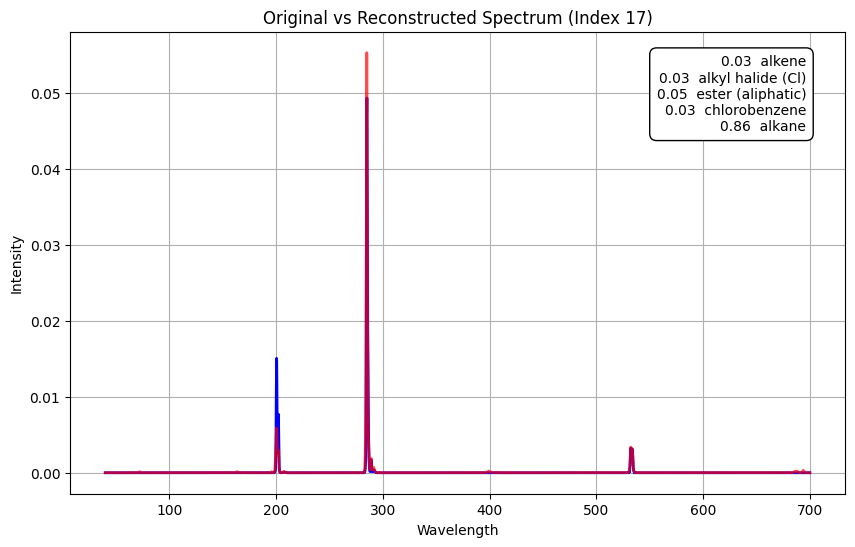

In [16]:
index = 17



example_spectra_tensor  = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])




# Get the specific example
with torch.no_grad():
    X_example = example_spectra_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    y_example = example_label_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Generate the reconstructed spectrum
    recon_example, mu, log_var = model(X_example, y_example)
    MSE =  recon_loss(recon_example, X_example)
    
# Move data back to CPU for plotting
X_example = X_example.cpu().squeeze()  # Remove batch dimension
y_example_list = y_example.cpu().squeeze().tolist()
recon_example = recon_example.cpu().squeeze().tolist()  # Remove batch dimension
recon_example = normalize_spectrum_by_area(recon_example)
print(sum(recon_example))

MSE_NP = MSE.cpu().numpy()
print(MSE_NP)


plt.figure(figsize=(10, 6))
plt.plot(BE_values, X_example, color="blue", linewidth=2)
plt.plot(BE_values,recon_example,  color="red", linestyle="-", linewidth=2,alpha =0.7)

label_text = label_converter(y_example_list,FG_list)

if not label_text:
    box = 'no functional groups'
else:
    box = "\n".join(label_text)
        
plt.text(0.95, 0.95, box, 
         ha='right', va='top',  # Horizontal and vertical alignment
         fontsize=10, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
         transform=plt.gca().transAxes)  # Place box in top right

plt.title(f"Original vs Reconstructed Spectrum (Index {index})")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.grid(True)


# Set limits using the axes object
plt.xlim()
plt.ylim() 

plt.show()


Sum of normalized reconstructed spectrum area: 1.0000003576278687
MSE: 0.0003664507530629635


/tmp/ipykernel_3762069/4013729812.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect


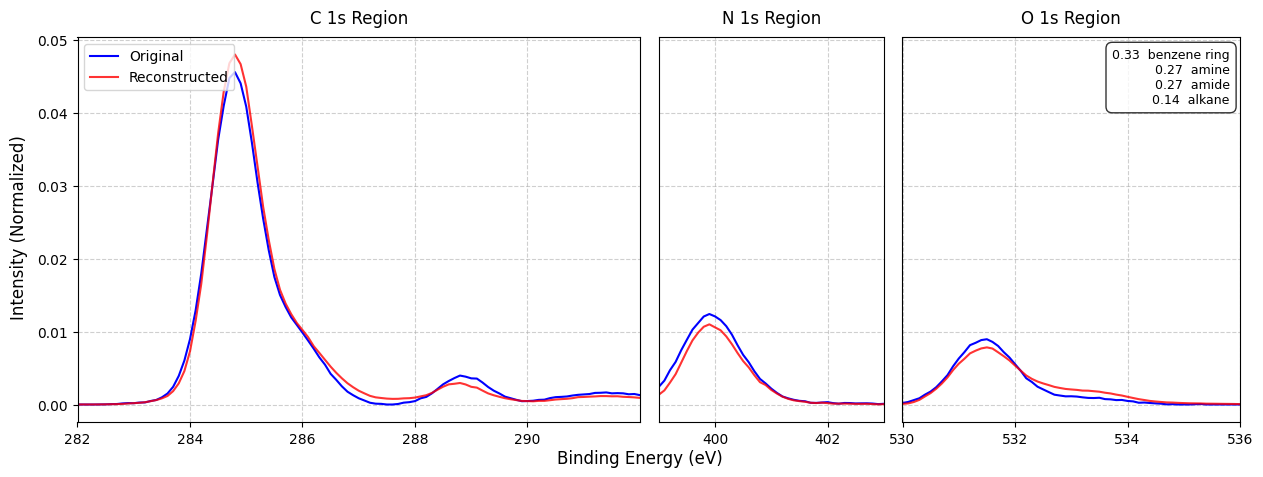

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported

# Assuming you have these functions defined elsewhere:
# from your_utils import normalize_spectrum_by_area, label_converter, FG_list, BE_values, recon_loss
# Assuming 'model', 'test_spectra', 'test_labels', 'device' are already defined and loaded

# 
# --- Configuration ---
index = 14

# Define ALL potential regions of interest and their titles
all_regions = [
    (282, 292),   # Region 1: C 1s
    (399, 403),   # Region 2: N 1s (Set include_region_2 = False to hide this)
    (530, 536)    # Region 3: O 1s
    # Add more regions here if needed

]
all_region_titles = ["C 1s Region", "N 1s Region", "O 1s Region"]
include_region_1 = True
include_region_2 = True # Set back to True for demonstration, or keep False
include_region_3 = True
include_flags = [include_region_1, include_region_2, include_region_3]

# --- !! New Configuration: Tick Interval !! ---
x_tick_interval = 2.0 # Set desired interval (e.g., ticks every 2 eV)

# --- Filter regions based on flags (Same as before) ---
active_regions = []
active_region_titles = []
active_widths = []
if len(all_regions) != len(all_region_titles) or len(all_regions) != len(include_flags):
    raise ValueError("Mismatch in length between regions, titles, and flags!")
for i, include in enumerate(include_flags):
    if include:
        region = all_regions[i]
        active_regions.append(region)
        active_region_titles.append(all_region_titles[i])
        active_widths.append(region[1] - region[0])
if not active_regions:
    print("No regions selected for plotting. Exiting.")
    exit()
num_active_regions = len(active_regions)

# --- Data Loading and Model Inference (Same as before) ---
example_spectra_tensor = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])
with torch.no_grad():
    X_example_gpu = example_spectra_tensor.unsqueeze(0).to(device)
    y_example_gpu = example_label_tensor.unsqueeze(0).to(device)
    recon_example_gpu, mu, log_var = model(X_example_gpu, y_example_gpu)
    MSE = recon_loss(recon_example_gpu, X_example_gpu)
X_example = X_example_gpu.cpu().squeeze().numpy()
y_example_list = y_example_gpu.cpu().squeeze().tolist()
recon_example_raw = recon_example_gpu.cpu().squeeze().numpy()
recon_example = normalize_spectrum_by_area(recon_example_raw)
print(f"Sum of normalized reconstructed spectrum area: {sum(recon_example)}")
MSE_NP = MSE.cpu().numpy()
print(f"MSE: {MSE_NP}")

# --- Plotting Setup (Uses filtered lists) ---
fig = plt.figure(figsize=(5 * num_active_regions, 5))
gs = fig.add_gridspec(1, num_active_regions, width_ratios=active_widths, wspace=0.05)
axes = []
for i in range(num_active_regions):
    share_y_ax = axes[0] if i > 0 else None
    ax = fig.add_subplot(gs[i], sharey=share_y_ax)
    axes.append(ax)

# --- Plotting Data on Each Active Axis ---
for i, ax in enumerate(axes):
    # Plot original spectrum
    ax.plot(BE_values, X_example, color="blue", linewidth=1.5, label='Original' if i == 0 else "")
    # Plot reconstructed spectrum
    ax.plot(BE_values, recon_example, color="red", linestyle="-", linewidth=1.5, alpha=0.8, label='Reconstructed' if i == 0 else "")

    # Set the x-axis limits for the current ACTIVE region
    ax.set_xlim(*active_regions[i])

    # --- !! Calculate and Set Consistent Ticks !! ---
    xmin, xmax = ax.get_xlim()
    # Calculate the first tick >= xmin at the interval step
    start_tick = np.ceil(xmin / x_tick_interval) * x_tick_interval
    # Calculate the last tick <= xmax at the interval step
    end_tick = np.floor(xmax / x_tick_interval) * x_tick_interval

    # Generate ticks, handle cases where range is small or doesn't contain interval steps
    if start_tick > end_tick + 1e-6: # Add small epsilon for float comparison
         # If range is too small for the interval, maybe use default ticks or just endpoints?
         # Option: Use Matplotlib's default for this small range
         calculated_ticks = ax.get_xticks() # Keep default ticks if range is smaller than interval
         print(f"Warning: Region {i+1} ({xmin:.1f}-{xmax:.1f}) is smaller than tick interval {x_tick_interval}. Using default ticks.")
    elif np.isclose(start_tick, end_tick):
        # Only one tick position falls within the range based on the interval
        calculated_ticks = np.array([start_tick])
    else:
        # Generate ticks within the calculated range
        calculated_ticks = np.arange(start_tick, end_tick + x_tick_interval * 0.1, x_tick_interval)

    # --- !! Conditionally Remove Last Tick from First Axis !! ---
    if i == 0 and num_active_regions > 1 and len(calculated_ticks) > 1:
        final_ticks = calculated_ticks[:-1] # Remove the last calculated tick for ax1
    else:
        final_ticks = calculated_ticks # Use all calculated ticks for other axes

    ax.set_xticks(final_ticks) # Apply the calculated (and potentially trimmed) ticks

    # --- Apply Grid (Now based on consistent ticks) ---
    ax.grid(True, linestyle='--', alpha=0.6)

    # Set individual region titles
    ax.set_title(active_region_titles[i], pad=10, fontsize=12)

    # Customize y-ticks for non-first plots
    if i > 0:
        ax.tick_params(left=False, labelleft=False)

# --- Add Text Box with Labels (Same as before) ---
label_text = label_converter(y_example_list, FG_list)
if not label_text: box_text = 'No functional groups'
else: box_text =  "\n".join(label_text)
axes[-1].text(0.97, 0.97, box_text, ha='right', va='top', fontsize=9,
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5'),
             transform=axes[-1].transAxes)

# --- Add Overall Figure Elements ---=
fig.supxlabel("Binding Energy (eV)", fontsize=12, y=0.02)

# --- !! Adjust Y-axis Super Label Position !! ---
# Decrease the 'x' value to move it left, closer to the axis
fig.supylabel("Intensity (Normalized)", fontsize=12, x=0.08) # Adjust x (e.g., 0.02, 0.01)

# Add legend (if at least one axis exists)
if axes: axes[0].legend(loc='upper left')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect

plt.show()

## Plot Generated Spectrum

Text(0.5, 1.0, 'Core Region')

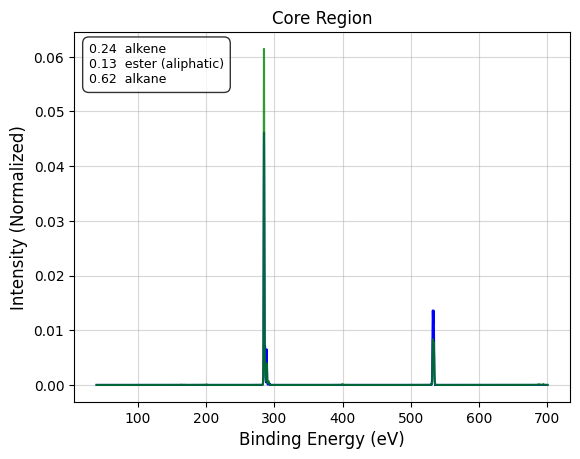

In [25]:
index =  6
example_spectra_tensor = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])

z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
with torch.no_grad():
    X_example_gpu = example_spectra_tensor.unsqueeze(0).to(device)
    y_example_gpu = example_label_tensor.unsqueeze(0).to(device)
    recon_example_gpu =  model.decode(z, y_example_gpu)
    MSE = recon_loss(recon_example_gpu, X_example_gpu)

    
X_example = X_example_gpu.cpu().squeeze().numpy()
y_example_list = y_example_gpu.cpu().squeeze().tolist()
recon_example_raw = recon_example_gpu.cpu().squeeze().numpy()
recon_example = normalize_spectrum_by_area(recon_example_raw)

plt.plot(BE_values, X_example, color="blue", linewidth=1.5, label='Reference')
plt.plot(BE_values, recon_example, color="Green", linestyle="-", linewidth=1.5, alpha=0.8, label='Generated')
plt.grid(True, alpha =0.5)

plt.xlabel("Binding Energy (eV)", fontsize=12)
plt.ylabel("Intensity (Normalized)", fontsize=12)
# --- Add Text Box with Labels (Same as before) ---
label_text = label_converter(y_example_list, FG_list)
if not label_text: box_text = 'No functional groups'
else: box_text =  "\n".join(label_text)
plt.text(0.03, 0.97, box_text, ha='left', va='top', fontsize=9,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5'),
         transform=plt.gca().transAxes)
plt.title("Core Region")

Sum of normalized reconstructed spectrum area: 1.0000593662261963
MSE: 0.0009792486671358347


/tmp/ipykernel_3762069/2720019555.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect


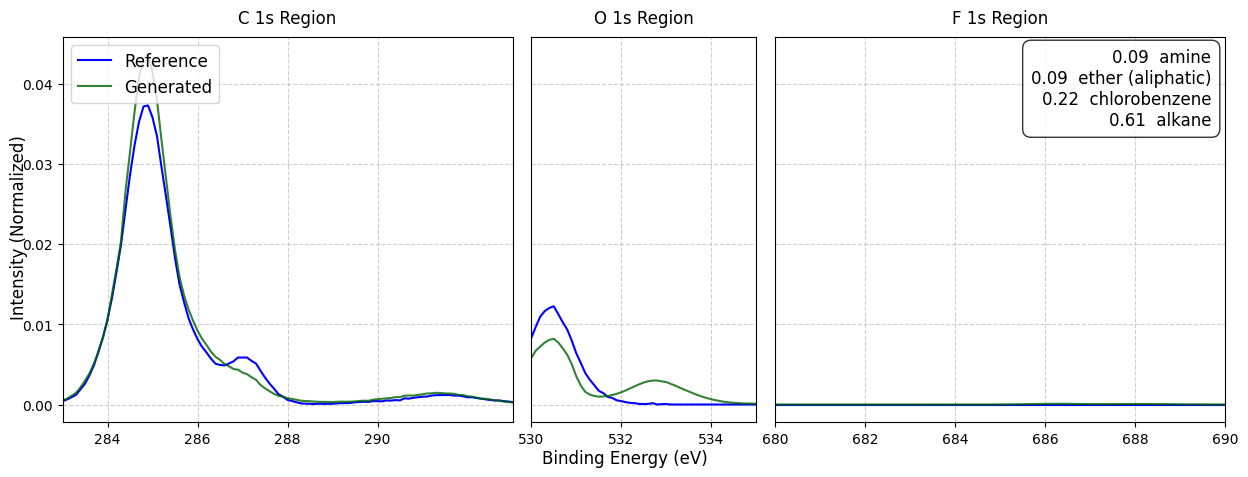

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0865, 0.0000, 0.0000, 0.0000, 0.0865,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2180, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6090])


In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported

# Assuming you have these functions defined elsewhere:
# from your_utils import normalize_spectrum_by_area, label_converter, FG_list, BE_values, recon_loss
# Assuming 'model', 'test_spectra', 'test_labels', 'device' are already defined and loaded

# 
# --- Configuration ---
index = 15
example_spectra_tensor = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])


# Define ALL potential regions of interest and their titles
all_regions = [
    (198,210),
    (283, 293), 
    (397,401), # Region 1: C 1s
    (530, 535),
    (680, 690)    # Region 3: O 1s
    # Add more regions here if needed

]
all_region_titles = ["Cl 2p Region", "C 1s Region", "N 1s Region", "O 1s Region", "F 1s Region"]
include_region_1 = False
include_region_2 = True # Set back to True for demonstration, or keep False
include_region_3 = False
include_region_4 = True
include_region_5 =True
include_flags = [include_region_1, include_region_2, include_region_3,  include_region_4, include_region_5]

# --- !! New Configuration: Tick Interval !! ---
x_tick_interval = 2.0 # Set desired interval (e.g., ticks every 2 eV)

# --- Filter regions based on flags (Same as before) ---
active_regions = []
active_region_titles = []
active_widths = []
if len(all_regions) != len(all_region_titles) or len(all_regions) != len(include_flags):
    raise ValueError("Mismatch in length between regions, titles, and flags!")
for i, include in enumerate(include_flags):
    if include:
        region = all_regions[i]
        active_regions.append(region)
        active_region_titles.append(all_region_titles[i])
        active_widths.append(region[1] - region[0])
if not active_regions:
    print("No regions selected for plotting. Exiting.")
    exit()
num_active_regions = len(active_regions)

z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
with torch.no_grad():
    X_example_gpu = example_spectra_tensor.unsqueeze(0).to(device)
    y_example_gpu = example_label_tensor.unsqueeze(0).to(device)
    recon_example_gpu =  model.decode(z, y_example_gpu)
    MSE = recon_loss(recon_example_gpu, X_example_gpu)

    
X_example = X_example_gpu.cpu().squeeze().numpy()
y_example_list = y_example_gpu.cpu().squeeze().tolist()
recon_example_raw = recon_example_gpu.cpu().squeeze().numpy()
recon_example = normalize_spectrum_by_area(recon_example_raw)
print(f"Sum of normalized reconstructed spectrum area: {sum(recon_example)}")
MSE_NP = MSE.cpu().numpy()
print(f"MSE: {MSE_NP}")

# --- Plotting Setup (Uses filtered lists) ---
fig = plt.figure(figsize=(5 * num_active_regions, 5))
gs = fig.add_gridspec(1, num_active_regions, width_ratios=active_widths, wspace=0.05)
axes = []
for i in range(num_active_regions):
    share_y_ax = axes[0] if i > 0 else None
    ax = fig.add_subplot(gs[i], sharey=share_y_ax)
    axes.append(ax)

# --- Plotting Data on Each Active Axis ---
for i, ax in enumerate(axes):
    # Plot original spectrum
    ax.plot(BE_values, X_example, color="blue", linewidth=1.5, label='Reference' if i == 0 else "")
    # Plot reconstructed spectrum
    ax.plot(BE_values, recon_example, color="darkgreen", linestyle="-", linewidth=1.5, alpha=0.8, label='Generated' if i == 0 else "")

    # Set the x-axis limits for the current ACTIVE region
    ax.set_xlim(*active_regions[i])

    # --- !! Calculate and Set Consistent Ticks !! ---
    xmin, xmax = ax.get_xlim()
    # Calculate the first tick >= xmin at the interval step
    start_tick = np.ceil(xmin / x_tick_interval) * x_tick_interval
    # Calculate the last tick <= xmax at the interval step
    end_tick = np.floor(xmax / x_tick_interval) * x_tick_interval

    # Generate ticks, handle cases where range is small or doesn't contain interval steps
    if start_tick > end_tick + 1e-6: # Add small epsilon for float comparison
         # If range is too small for the interval, maybe use default ticks or just endpoints?
         # Option: Use Matplotlib's default for this small range
         calculated_ticks = ax.get_xticks() # Keep default ticks if range is smaller than interval
         print(f"Warning: Region {i+1} ({xmin:.1f}-{xmax:.1f}) is smaller than tick interval {x_tick_interval}. Using default ticks.")
    elif np.isclose(start_tick, end_tick):
        # Only one tick position falls within the range based on the interval
        calculated_ticks = np.array([start_tick])
    else:
        # Generate ticks within the calculated range
        calculated_ticks = np.arange(start_tick, end_tick + x_tick_interval * 0.1, x_tick_interval)

    # --- !! Conditionally Remove Last Tick from First Axis !! ---
    if i == 0 and num_active_regions > 1 and len(calculated_ticks) > 1:
        final_ticks = calculated_ticks[:-1] # Remove the last calculated tick for ax1
    else:
        final_ticks = calculated_ticks # Use all calculated ticks for other axes

    ax.set_xticks(final_ticks) # Apply the calculated (and potentially trimmed) ticks

    # --- Apply Grid (Now based on consistent ticks) ---
    ax.grid(True, linestyle='--', alpha=0.6)

    # Set individual region titles
    ax.set_title(active_region_titles[i], pad=10, fontsize=12)

    # Customize y-ticks for non-first plots
    if i > 0:
        ax.tick_params(left=False, labelleft=False)

# --- Add Text Box with Labels (Same as before) ---
label_text = label_converter(y_example_list, FG_list)
if not label_text: box_text = 'No functional groups'
else: box_text =  "\n".join(label_text)
axes[-1].text(0.97, 0.97, box_text, ha='right', va='top', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5'),
             transform=axes[-1].transAxes)

# --- Add Overall Figure Elements ---=
fig.supxlabel("Binding Energy (eV)", fontsize=12, y=0.02)

# --- !! Adjust Y-axis Super Label Position !! ---
# Decrease the 'x' value to move it left, closer to the axis
fig.supylabel("Intensity (Normalized)", fontsize=12, x=0.09) # Adjust x (e.g., 0.02, 0.01)

# Add legend (if at least one axis exists)
if axes: axes[0].legend(loc='upper left', fontsize =12)


plt.savefig("my_figure.png", dpi=300, bbox_inches='tight')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 0.98, 0.92]) # May need slight adjustments to rect
plt.show()
print(example_label_tensor)

In [27]:
indices  = (range(1000))
MSE_list = []

for index in indices:
    example_spectra_tensor = torch.tensor(test_spectra[index])
    example_label_tensor = torch.tensor(test_labels[index])
    z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
    with torch.no_grad():
        X_example_gpu = example_spectra_tensor.unsqueeze(0).to(device)
        y_example_gpu = example_label_tensor.unsqueeze(0).to(device)
        recon_example_gpu =  model.decode(z, y_example_gpu)
        MSE = recon_loss(recon_example_gpu, X_example_gpu)
        MSE_NP = MSE.cpu().numpy()
    MSE_list.append(MSE_NP)

for i, MSE in enumerate(MSE_list):
    if 1.85e-3 <= MSE < 1.95e-3:  # Checks if the number would round to 1.9
        print(i)

MSE_avg = (sum(MSE_list) / len(MSE_list))
MSE_df = pd.DataFrame(MSE_list, columns=['MSE'])
MSE_df.index.name = 'Index'
print(MSE_df)
print(MSE_avg)


184
231
266
269
420
552
596
604
636
651
741
862
977
            MSE
Index          
0      0.001294
1      0.000570
2      0.002015
3      0.001005
4      0.001696
...         ...
995    0.001333
996    0.000240
997    0.000264
998    0.000277
999    0.001183

[1000 rows x 1 columns]
0.0022492881


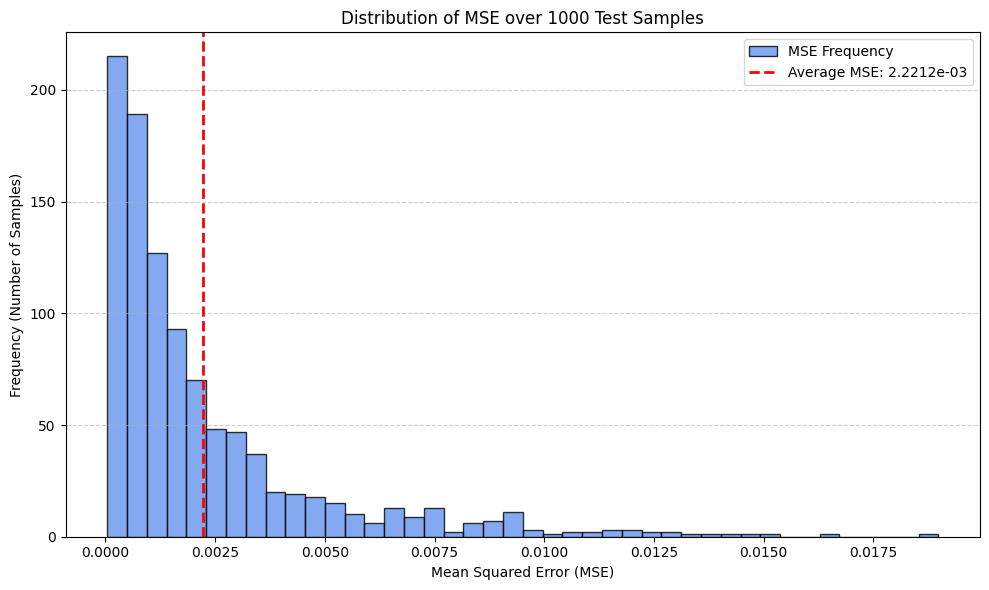


--- MSE Statistics ---
Number of Samples: 1000
Average MSE: 2.2212e-03
Median MSE:  1.2906e-03
Std Dev MSE: 2.6045e-03
Min MSE:     4.1704e-05
Max MSE:     1.8982e-02
25th Percentile: 5.5082e-04
75th Percentile: 2.8087e-03


In [18]:
# Make sure matplotlib is installed (pip install matplotlib)
# Ensure necessary imports are present (might be in a previous cell)
import matplotlib.pyplot as plt
import numpy as np # Used for stats

# Assumes MSE_list and MSE_avg are available from the previous cell execution

# --- Create the Histogram ---
plt.figure(figsize=(10, 6)) # Adjust figure size as needed

# Plot the histogram
# bins='auto' usually provides a reasonable number of bins.
# You can also specify an integer (e.g., bins=30) or a sequence of bin edges.
plt.hist(MSE_list, bins='auto', color='cornflowerblue', edgecolor='black', alpha=0.8, label='MSE Frequency')

# Add a vertical line for the average MSE
plt.axvline(MSE_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average MSE: {MSE_avg:.4e}')

# Add labels and title
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Frequency (Number of Samples)")
plt.title(f"Distribution of MSE over {len(MSE_list)} Test Samples")

# Add a grid (optional, for the y-axis can be helpful)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add legend to show the average line label
plt.legend()

# Improve layout to prevent labels overlapping
plt.tight_layout()

# Show the plot
plt.show()

# --- Optional: Print summary statistics ---
# Convert to numpy array for easier statistics
mse_array = np.array(MSE_list)
print("\n--- MSE Statistics ---")
print(f"Number of Samples: {len(mse_array)}")
print(f"Average MSE: {MSE_avg:.4e}") # Already calculated
print(f"Median MSE:  {np.median(mse_array):.4e}")
print(f"Std Dev MSE: {np.std(mse_array):.4e}")
print(f"Min MSE:     {np.min(mse_array):.4e}")
print(f"Max MSE:     {np.max(mse_array):.4e}")
# You could also print percentiles if interested
print(f"25th Percentile: {np.percentile(mse_array, 25):.4e}")
print(f"75th Percentile: {np.percentile(mse_array, 75):.4e}")

In [19]:
def calculate_mae(generated_spectrum, target_spectrum):
    """
    Calculates the Mean Absolute Error (MAE) between two spectra.

    Args:
        generated_spectrum (torch.Tensor): The generated spectrum.
        target_spectrum (torch.Tensor): The target spectrum.

    Returns:
        float: The MAE between the two spectra.
    """

    # Calculate the absolute difference
    absolute_difference = torch.abs(generated_spectrum - target_spectrum)

    # Calculate the mean
    mae = torch.mean(absolute_difference).item()  # Get scalar value

    return mae

In [20]:
def recon_loss(recon_x, x):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    return MSE

In [19]:
input_dim = 6601
cond_dim = 40
latent_dim = 1


model_name =  "CVAE1d(1latentvar).pth"
#newCVAE1d.pth 
# "best_CVAE_12d.pth" - pretty good
# "CVAE_2d.pth" - bad
# "CVAE_3d_goat.pth" - bad

local_models_dir = "/home/issa/new_project_clone/local_models/"

model_path = os.path.join(local_models_dir , model_name)

# Initialize model
model = CVAE_Option2(input_dim, latent_dim, cond_dim).to(device)
# Load the trained model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


CVAE_Option2(
  (encoder_layers): Sequential(
    (0): Linear(in_features=6641, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu_logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=41, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bi

In [ ]:


# --- Configuration ---
# Define your spectral regions {Region Name: (min_eV, max_eV)}
spectral_regions = {
    "Carbon broad": (280, 295),
    "Oxygen": (530, 545),      # Adjust ranges as needed for your data
    "Nitrogen": (397, 405),    # Adjust ranges as needed
    "Fluorine (F 1s)": (684, 694),   # Very characteristic region for F
    "Sulphur (S 2p)": (160, 172),    # For sulphides, sulphones, sulphonates (doublet region)
    "Chlorine (Cl 2p)": (195, 206),   # For chlorinated polymers (doublet region)
    "Bromine (Br 3d)": (67, 74),     # For brominated polymers (doublet region)
    # Add or remove regions as needed
}

# Define the threshold for a region's area in the REFERENCE spectrum
# to be considered "significant". This is crucial for relative error
# to avoid division by zero or very small numbers.
SIGNIFICANT_AREA_THRESHOLD = 0.02 # e.g., Area must be > 2% of the total spectrum area

num_tests_indices = range(1, 1000) # Use range(len(test_spectra)) for all data, ensure this range is valid
num_samples_processed = len(num_tests_indices) # Keep track of total samples looped over

# Ensure BE_values is a NumPy array for efficient boolean indexing
be_values_np = np.array(BE_values)

# --- Initialization ---
# Store SUM of RELATIVE errors
total_relative_error_by_region = {region: 0.0 for region in spectral_regions}
# Store SUM of ABSOLUTE deviations (as fraction of total area)
total_absolute_deviation_by_region = {region: 0.0 for region in spectral_regions}
# <<< ADDED >>> Store SUM of REFERENCE areas for active samples
total_reference_area_by_region = {region: 0.0 for region in spectral_regions}
# Store COUNT of samples where reference region is active
active_region_counts = {region: 0 for region in spectral_regions}

# --- Helper Function for Normalization ---
def normalize_spectrum_by_area(spectrum_np):
    """Normalizes a NumPy spectrum array so its area (sum) is 1."""
    spectrum_np = np.maximum(spectrum_np, 0)
    total_area = np.sum(spectrum_np)
    if total_area > 1e-9:
        return spectrum_np / total_area
    else:
        return np.zeros_like(spectrum_np)

# --- Main Loop ---
print(f"Starting analysis on {num_samples_processed} samples...")
print(f"Using significant area threshold: {SIGNIFICANT_AREA_THRESHOLD:.3f}")

for i in num_tests_indices:
    # Ensure data is float32 for the model
    try:
        example_spectra_tensor = torch.tensor(test_spectra[i], dtype=torch.float32)
        example_label_tensor = torch.tensor(test_labels[i], dtype=torch.float32)
    except Exception as e:
        print(f"Error converting data at index {i} to tensor: {e}")
        continue # Skip this sample

    # Prepare tensors for the model
    with torch.no_grad():
        X_example = example_spectra_tensor.unsqueeze(0).to(device)
        y_example = example_label_tensor.unsqueeze(0).to(device) # Labels needed for CVAE decoder
        z = torch.randn(1, latent_dim).to(device)
        generated_spectrum = model.decode(z, y_example) # Shape: (1, num_points)

    # --- Area Calculation & Error Accumulation ---
    X_example_np_orig = X_example.cpu().squeeze().numpy()
    generated_spectrum_np_orig = generated_spectrum.cpu().squeeze().numpy()
    X_example_np_norm_area = normalize_spectrum_by_area(X_example_np_orig)
    generated_spectrum_np_norm_area = normalize_spectrum_by_area(generated_spectrum_np_orig)

    for region_name, (min_be, max_be) in spectral_regions.items():
        region_indices = np.where((be_values_np >= min_be) & (be_values_np <= max_be))[0]
        if region_indices.size > 0:
            ref_area_region = np.sum(X_example_np_norm_area[region_indices])
            if ref_area_region > SIGNIFICANT_AREA_THRESHOLD:
                # <<< ADDED >>> Accumulate reference area when active
                total_reference_area_by_region[region_name] += ref_area_region

                # --- Calculate errors and accumulate ---
                gen_area_region = np.sum(generated_spectrum_np_norm_area[region_indices])
                absolute_deviation = abs(gen_area_region - ref_area_region)
                relative_error = absolute_deviation / ref_area_region

                total_relative_error_by_region[region_name] += relative_error
                total_absolute_deviation_by_region[region_name] += absolute_deviation
                active_region_counts[region_name] += 1


# --- Calculate Average Errors and Reference Area ---
average_errors_by_active_region = {} # Dictionary to store final results
print("\n--- Calculating Averages ---")

for region_name in spectral_regions:
    count = active_region_counts[region_name]

    if count > 0:
        total_rel_err = total_relative_error_by_region[region_name]
        total_abs_dev = total_absolute_deviation_by_region[region_name]
        # <<< ADDED >>> Get total reference area sum
        total_ref_area = total_reference_area_by_region[region_name]

        # Calculate averages for all metrics
        average_rel_err = total_rel_err / count
        average_abs_dev = total_abs_dev / count
        # <<< ADDED >>> Calculate average reference area
        average_ref_area = total_ref_area / count

        average_errors_by_active_region[region_name] = {
            'average_relative_error': average_rel_err,
            'average_absolute_deviation': average_abs_dev,
            # <<< ADDED >>> Store average reference area
            'average_reference_area': average_ref_area,
            'active_sample_count': count
        }
    else:
        # Handle cases where a region was never active above the threshold
         average_errors_by_active_region[region_name] = {
            'average_relative_error': None,
            'average_absolute_deviation': None,
            # <<< ADDED >>> Store None for reference area too
            'average_reference_area': None,
            'active_sample_count': 0
        }

# --- Output Results ---
print("\n--- Final Results ---")
print(f"Analysis based on {num_samples_processed} total samples processed.")
print(f"Significance threshold for region activity in reference spectrum: > {SIGNIFICANT_AREA_THRESHOLD*100:.1f}% of total area")

# <<< MODIFIED >>> Title reflects new column
print("\nAverage Area Errors and Reference Area by Region (calculated ONLY for samples where reference region was active):")
if average_errors_by_active_region:
    # <<< MODIFIED >>> Added column header for Avg. Ref. Area (%)
    print(f"  {'Region':<17} {'Range (eV)':<12} | {'Avg. Ref. Area (%)':<19} | {'Avg. Rel. Error (%)':<20} | {'Avg. Abs. Dev. (pp)':<22} | {'Active Samples':<15}")
    print(f"  {'-'*17} {'-'*12} | {'-'*19} | {'-'*20} | {'-'*22} | {'-'*15}") # Separator line

    for region_name, results in average_errors_by_active_region.items():
        min_be, max_be = spectral_regions[region_name]
        range_str = f"{min_be}-{max_be}"
        count = results['active_sample_count']
        avg_rel_err = results['average_relative_error']
        avg_abs_dev = results['average_absolute_deviation']
        # <<< ADDED >>> Retrieve average reference area
        avg_ref_area = results['average_reference_area']

        # Format results or N/A
        # <<< ADDED >>> Format average reference area string (as percentage)
        ref_area_str = f"{avg_ref_area*100:6.2f}%" if avg_ref_area is not None else "N/A"
        rel_err_str = f"{avg_rel_err*100:6.2f}%" if avg_rel_err is not None else "N/A"
        abs_dev_str = f"{avg_abs_dev*100:6.2f} pp" if avg_abs_dev is not None else "N/A"
        count_str = f"{count}"

        # <<< MODIFIED >>> Print formatted row including the new reference area column
        print(f"  {region_name:<17} {range_str:<12} | {ref_area_str:<19} | {rel_err_str:<20} | {abs_dev_str:<22} | {count_str:<15}")
else:
    print("  No error results calculated or stored.")

print("\nAnalysis complete.")

Starting analysis on 999 samples...
Using significant area threshold: 0.020

--- Calculating Averages ---

--- Final Results ---
Analysis based on 999 total samples processed.
Significance threshold for region activity in reference spectrum: > 2.0% of total area

Average Area Errors and Reference Area by Region (calculated ONLY for samples where reference region was active):
  Region            Range (eV)   | Avg. Ref. Area (%)  | Avg. Rel. Error (%)  | Avg. Abs. Dev. (pp)    | Active Samples 
  ----------------- ------------ | ------------------- | -------------------- | ---------------------- | ---------------
  Total             40-700       | 100.00%             |   0.00%              |   0.00 pp              | 999            
  Carbon broad      280-295      |  57.39%             |  21.18%              |  11.04 pp              | 998            
  Oxygen            530-545      |  33.98%             |  55.36%              |  11.05 pp              | 915            
  Nitrogen       

In [32]:
import collections
num_tests = range(1,10000)


MSE_by_num_fgs = collections.defaultdict(list) 

for i in num_tests :

    example_spectra_tensor  = torch.tensor(test_spectra[i])
    example_label_tensor = torch.tensor(test_labels[i])

    # Get the specific example
    with torch.no_grad():
        X_example = example_spectra_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        y_example = example_label_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Generate latent vector
    z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector

    # Decode the latent vector to generate spectra
    with torch.no_grad():  # No need to track gradients
        generated_spectrum = model.decode(z, y_example)

    # Move data back to CPU for plotting
    y_example_list = y_example.cpu().squeeze().tolist()
    generated_spectrum_norm = generated_spectrum / torch.sum(generated_spectrum)

    MSE = recon_loss(generated_spectrum_norm, X_example).cpu().numpy().item()



    generated_spectrum_norm_np = generated_spectrum.cpu().squeeze()
    X_example_np = X_example.cpu().squeeze()  # Remove batch dimension
    
    num_fgs = torch.count_nonzero(y_example).item()
    MSE_by_num_fgs[num_fgs].append(MSE)

    #normalised_generated_spectra = normalize_spectra_by_area(np.array(generated_spectra)).squeeze()
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(BE_values, X_example, color="blue", linewidth=2)
    plt.plot(BE_values, normalize_spectrum_by_area(generated_spectrum), color="red", linestyle="-", linewidth=2, alpha=0.7)
    #plt.plot(normalised_generated_spectra, color="green", linestyle="-", linewidth=2, alpha=0.7)
    '''

    label_text = label_converter(y_example_list, FG_list)

    if not label_text:
        box = 'no functional groups'
    else:
        box = "\n".join(label_text)

    
    

    '''
    plt.text(0.95, 0.95, box, 
            ha='right', va='top',  # Horizontal and vertical alignment
            fontsize=10, 
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
            transform=plt.gca().transAxes)  # Place box in top right


    plt.title(f"Original vs Generated Spectrum (Example {index})")
    plt.xlabel("BE / eV")
    plt.ylabel("Relative Intensity")
    plt.grid(True)

    # Set limits using the axes object
    plt.xlim()
    plt.ylim() 
    '''

print(MSE_by_num_fgs)


defaultdict(<class 'list'>, {3: [0.0005481962580233812, 0.0009533728007227182, 0.001688012620434165, 0.001630781451240182, 0.0018466506153345108, 0.0015578796155750751, 0.0012744148261845112, 0.007952754385769367, 0.002821484813466668, 0.012403102591633797, 0.0007244452135637403, 0.0008436415810137987, 0.0007108187419362366, 0.00137414934579283, 0.0014518945245072246, 0.0004147490835748613, 0.0011666860664263368, 0.0013779249275103211, 0.0011715786531567574, 0.00028525490779429674, 0.00039870062028057873, 0.001994139514863491, 0.00045401943498291075, 0.00022338311828207225, 0.0014479225501418114, 0.002172341337427497, 0.00029025046387687325, 0.0002890342439059168, 0.0008526723831892014, 0.0009437891421839595, 0.0009753835620358586, 0.0005339216440916061, 0.000565327878575772, 0.00032772155827842653, 0.0010124463587999344, 0.00250971969217062, 0.001472924486733973, 0.001296276692301035, 0.002242609392851591, 0.0019210155587643385, 0.0005007729050703347, 0.0007678794208914042, 0.00178005

defaultdict(<class 'list'>, {3: [0.0005481962580233812, 0.0009533728007227182, 0.001688012620434165, 0.001630781451240182, 0.0018466506153345108, 0.0015578796155750751, 0.0012744148261845112, 0.007952754385769367, 0.002821484813466668, 0.012403102591633797, 0.0007244452135637403, 0.0008436415810137987, 0.0007108187419362366, 0.00137414934579283, 0.0014518945245072246, 0.0004147490835748613, 0.0011666860664263368, 0.0013779249275103211, 0.0011715786531567574, 0.00028525490779429674, 0.00039870062028057873, 0.001994139514863491, 0.00045401943498291075, 0.00022338311828207225, 0.0014479225501418114, 0.002172341337427497, 0.00029025046387687325, 0.0002890342439059168, 0.0008526723831892014, 0.0009437891421839595, 0.0009753835620358586, 0.0005339216440916061, 0.000565327878575772, 0.00032772155827842653, 0.0010124463587999344, 0.00250971969217062, 0.001472924486733973, 0.001296276692301035, 0.002242609392851591, 0.0019210155587643385, 0.0005007729050703347, 0.0007678794208914042, 0.00178005

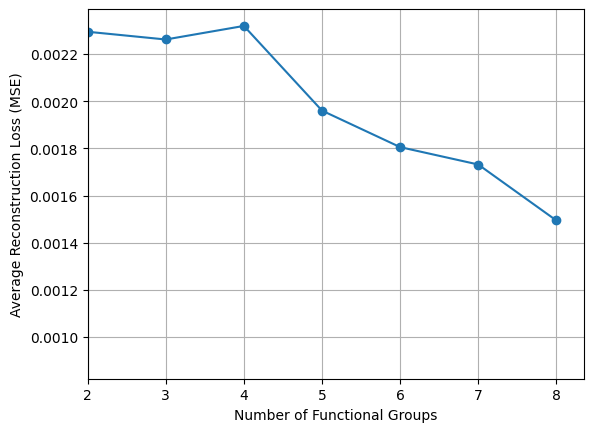

In [33]:
print(MSE_by_num_fgs)

average_losses = {}
for num_groups, losses in MSE_by_num_fgs.items():
    average_losses[num_groups] = sum(losses) / len(losses)

average_losses = dict(sorted(average_losses.items()))

print(average_losses)
# 4. Create a Pandas DataFrame
#    For easy manipulation and plotting, we'll create a Pandas DataFrame from the


df = pd.DataFrame(list(average_losses.items()), columns=['Functional Groups', 'Average Loss'])


# Calculate frequencies.
frequencies = {}
for num_groups in MSE_by_num_fgs.keys(): # changed from average_losses.keys()
    frequencies[num_groups] = len(MSE_by_num_fgs[num_groups]) #get the length of the list for the frequency of each group

# Add frequencies to the DataFrame.
df['Frequency'] = df['Functional Groups'].map(frequencies) #create a new column 'Frequency'

print(df)

# 5. Plotting the Results
#    A line plot is suitable for visualizing the relationship between the number of
#    functional groups and the average reconstruction loss.
plt.plot(df['Functional Groups'], df['Average Loss'], marker='o')
plt.xlabel('Number of Functional Groups')
plt.ylabel('Average Reconstruction Loss (MSE)')
plt.grid(True)
plt.xlim(2,)
plt.show()

defaultdict(<class 'list'>, {2: [7.183239358710125e-05, 8.951111522037536e-05, 6.015634789946489e-05, 5.914736902923323e-05, 5.7740526244742796e-05, 6.286369898589328e-05, 6.751727050868794e-05, 5.916251757298596e-05, 5.8941168390447274e-05, 5.262869308353402e-05, 7.191033364506438e-05, 8.738342876313254e-05, 5.867077561561018e-05, 6.0375536122592166e-05, 6.207002297742292e-05, 7.139187073335052e-05, 6.461307930294424e-05, 5.602507008006796e-05, 6.572118581971154e-05, 6.437075353460386e-05, 6.209279672475532e-05, 7.709285273449495e-05, 6.557253072969615e-05, 4.9933631089515984e-05, 7.105302938725799e-05, 5.744496229453944e-05, 6.406404281733558e-05, 9.73976930254139e-05, 8.541841089027002e-05, 5.933258944423869e-05, 5.286551095196046e-05, 5.5272761528613046e-05, 6.556688458658755e-05, 9.879002755042166e-05, 6.299395317910239e-05, 8.934160723583773e-05, 5.983285154798068e-05, 5.3706535254605114e-05, 6.31168732070364e-05, 6.20326172793284e-05, 8.827581768855453e-05, 6.453573587350547e-05

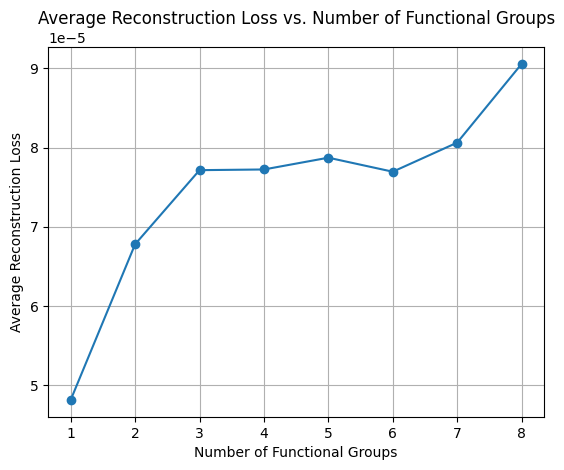

In [13]:
print(MAE_by_num_fgs)

average_losses = {}
for num_groups, losses in MAE_by_num_fgs.items():
    average_losses[num_groups] = sum(losses) / len(losses)

average_losses = dict(sorted(average_losses.items()))

print(average_losses)
# 4. Create a Pandas DataFrame
#    For easy manipulation and plotting, we'll create a Pandas DataFrame from the


df = pd.DataFrame(list(average_losses.items()), columns=['Functional Groups', 'Average Loss'])


# Calculate frequencies.
frequencies = {}
for num_groups in MAE_by_num_fgs.keys(): # changed from average_losses.keys()
    frequencies[num_groups] = len(MAE_by_num_fgs[num_groups]) #get the length of the list for the frequency of each group

# Add frequencies to the DataFrame.
df['Frequency'] = df['Functional Groups'].map(frequencies) #create a new column 'Frequency'

print(df)

# 5. Plotting the Results
#    A line plot is suitable for visualizing the relationship between the number of
#    functional groups and the average reconstruction loss.
plt.plot(df['Functional Groups'], df['Average Loss'], marker='o')
plt.xlabel('Number of Functional Groups')
plt.ylabel('Average Reconstruction Loss')
plt.title('Average Reconstruction Loss vs. Number of Functional Groups')
plt.grid(True)
plt.show()



In [8]:
import numpy as np
import os # Keep os for listdir if preferred, but pathlib is generally cleaner
from pathlib import Path
# import pandas as pd # No longer needed for reading labels

# 1. Update Directory Path (Use the absolute path provided)
# Use Path object for better path handling
labels_dir = Path('../data/synthetic_data_hard/synthetic_labels')

label_list = []
processed_filenames = [] # To store names for the DataFrame index

try:
    # Get .npy files and sort them in one go
    # Assumes filenames like 'prefix_1.npy', 'prefix_2.npy'
    all_npy_files = sorted(
        list(labels_dir.glob('*.npy')),
        key=lambda x: int(x.stem.split('_')[1])
    )
except (IndexError, ValueError):
    print(f"Warning: Could not sort by number, using default OS sort.")
    all_npy_files = sorted(list(labels_dir.glob('*.npy')))
except FileNotFoundError:
    print(f"Error: Directory not found: {labels_dir}")
    all_npy_files = []


# Loop through sorted files
for label_path in all_npy_files:
    try:
        # Load the numpy array
        label_array = np.load(label_path)

        # Normalize (handle sum=0 by returning zeros of same shape)
        array_sum = np.sum(label_array)
        # Using np.nan_to_num to handle division by zero robustly if needed,
        # or the conditional approach:
        if array_sum == 0:
            normalised_label = np.zeros_like(label_array) # Or label_array itself
        else:
            normalised_label = label_array / array_sum

        # Append the processed array and its filename
        label_list.append(normalised_label)
        processed_filenames.append(label_path.name)

    except Exception as e:
        # Minimal error reporting for problematic files
        print(f"Skipping file {label_path.name} due to error: {e}")


# --- Create final DataFrame ---
label_df = None # Initialize
if label_list:
    print(f"\nLoaded {len(label_list)} labels.")
    try:
        # Make sure FG_list length matches the data dimension
        if FG_list is None or len(FG_list) != len(label_list[0]):
             print(f"Warning: FG_list length mismatch (expected {len(label_list[0])}). Using default column names.")
             columns = None # Use default integer columns
        else:
             columns = FG_list

        # Create DataFrame using processed filenames and FG_list
        label_df = pd.DataFrame(
            label_list,
            index=processed_filenames,
            columns=columns
        )

        print("\nDataFrame preview:")
        print(label_df.head())
        print(f"\nDataFrame shape: {label_df.shape}")

    except Exception as e:
        print(f"Error creating final DataFrame: {e}")
else:
    print("No labels were loaded, DataFrame not created.")


Loaded 100000 labels.

DataFrame preview:
             alkene  alkyne  benzene ring  naphthalene     amine  \
label_0.npy     0.0     0.0      0.000000          0.0  0.000000   
label_1.npy     0.0     0.0      0.244923          0.0  0.122461   
label_2.npy     0.0     0.0      0.000000          0.0  0.000000   
label_3.npy     0.0     0.0      0.000000          0.0  0.000000   
label_4.npy     0.0     0.0      0.083208          0.0  0.000000   

             alcohol (aromatic)  alcohol (aliphatic)  ether (aromatic)  \
label_0.npy                 0.0                  0.0               0.0   
label_1.npy                 0.0                  0.0               0.0   
label_2.npy                 0.0                  0.0               0.0   
label_3.npy                 0.0                  0.0               0.0   
label_4.npy                 0.0                  0.0               0.0   

             ether (aliphatic)  alkyl halide (F)  ...  sulfone  sulfonate  \
label_0.npy           0.13

In [9]:
# 1. Pre-allocate memory and store all values for all classes before plotting
all_values = {class_name: [] for class_name in FG_list}  # Use a dictionary

# Iterate through the list of NumPy arrays
for label_array in label_list: # Changed variable name for clarity
    # Optional: Check if array length matches FG_list length for safety
    if len(label_array) == len(FG_list):
        # Iterate through the indices and class names simultaneously
        for i, class_name in enumerate(FG_list):
            # Access the value using NumPy integer indexing
            # No need for '.index' check or '.loc'
            value = label_array[i]
            # value = label_array[i].item() # Use .item() if you specifically need a Python scalar type

            if value > 0:  # Only include values greater than 0
                all_values[class_name].append(value)
    else:
        print(f"Warning: Skipping label array with length {len(label_array)}, expected {len(FG_list)}")

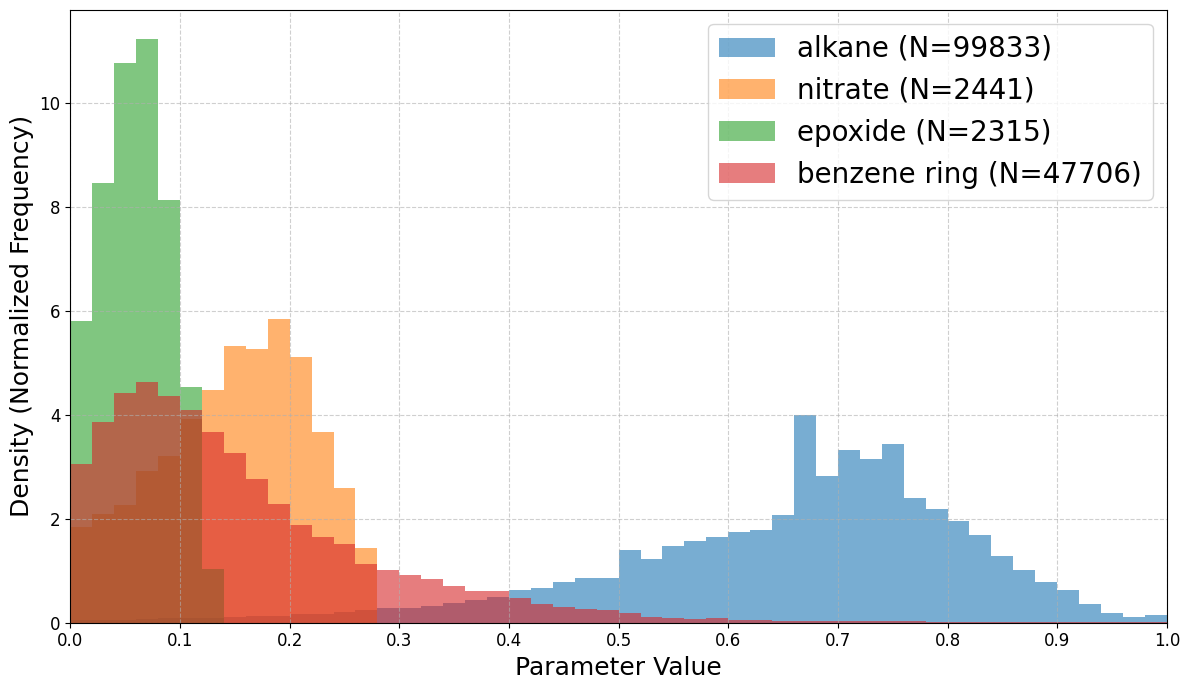

In [15]:
FGs_of_interest = ['alkane', 'nitrate', 'epoxide', 'benzene ring' ]

num_colors = len(FGs_of_interest)
colors = plt.cm.tab10.colors[:num_colors]


# Define number of bins
num_bins = 50
# Define the range and bins
bin_edges = np.linspace(0, 1, num_bins + 1)

# --- Corrected Plotting Code ---
plt.figure(figsize=(12, 7)) # Create a single figure

# Loop through each functional group of interest
for i, class_name in enumerate(FGs_of_interest):
    # Check if the class_name exists in the data and handle potential KeyError
    if class_name in all_values:
        values = all_values[class_name]
        # Ensure values is a numpy array for consistency
        values = np.asarray(values)

        # Check if there is data to plot for this group
        if values.size > 0:
            # Plot the normalized histogram using density=True
            # density=True ensures the area under the histogram integrates to 1
            plt.hist(values,
                     bins=bin_edges,
                     density=True, # Use density=True for normalization
                     alpha=0.6,    # Slightly increased alpha for better visibility
                     color=colors[i],
                     label=f"{class_name} (N={len(values)})") # Add count to label
        else:
            # Optional: Add a label for empty groups if desired, but don't plot histogram
             print(f"No data for {class_name}, skipping histogram.")
             # If you still want it in the legend even if empty:
             # plt.plot([], [], color=colors[i], label=f"{class_name} (N=0)") # Plot empty line for legend entry
    else:
        print(f"Class name '{class_name}' not found in all_values dictionary.")


# Add plot titles and labels
plt.xlabel('Parameter Value', fontsize = 18)
plt.ylabel('Density (Normalized Frequency)', fontsize = 18) # Y-axis is density when density=True

# --- Set X-axis Ticks ---
# Generate ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)
plt.xticks(x_ticks, fontsize =12)


# --- Set Y-axis Tick Label Size ---
plt.tick_params(axis='y', which='major', labelsize=12)  # Larger y-axis numbers

# --- Add Legend ---
# Place legend inside the plot area in the upper left corner
plt.legend(loc='upper right', fontsize = 20) # Changed location

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set x-axis limits (redundant with xticks but good practice)
plt.xlim(0, 1)

# Adjust layout to prevent labels from overlapping (may not be needed with legend inside)
plt.tight_layout() # Removed rect argument
plt.savefig('biased_synthetic_data.png',dpi =300)
# Show the plot
plt.show()


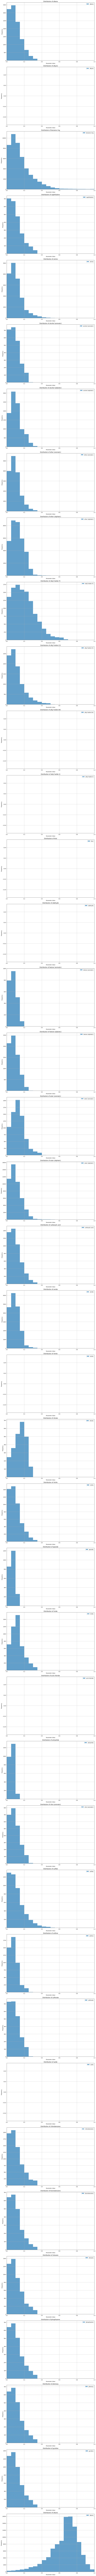

In [24]:

# 2. Plot all histograms at once
fig, axes = plt.subplots(len(FG_list), 1, figsize=(12, 8 * len(FG_list)))  # Increased figure size

for i, class_name in enumerate(FG_list):
    values = all_values[class_name]
    axes[i].hist(values, bins=np.linspace(0, 1, 21), alpha=0.7, label=class_name) #plot the histogram with bins between 0 and 1
    axes[i].set_title(f'Distribution of {class_name}')
    axes[i].set_xlabel('Parameter Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_xlim(0, 1)  # Set x-axis limits

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [12]:
for i, class_name in enumerate(FG_list):
    values = all_values[class_name]
    axes[i].hist(values, bins=np.linspace(0, 1, 21), alpha=0.7, label=class_name) #plot the histogram with bins between 0 and 1
    axes[i].set_title(f'Distribution of {class_name}')
    axes[i].set_xlabel('Parameter Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_xlim(0, 1)  # Set x-axis limits

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

NameError: name 'all_values' is not defined

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1148148849606514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13111107051372528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7540740370750427]
1.0
0.999998
1.0000015
1.0000006
0.9999964
area of synthetic spectrum: 0.9999996423721313


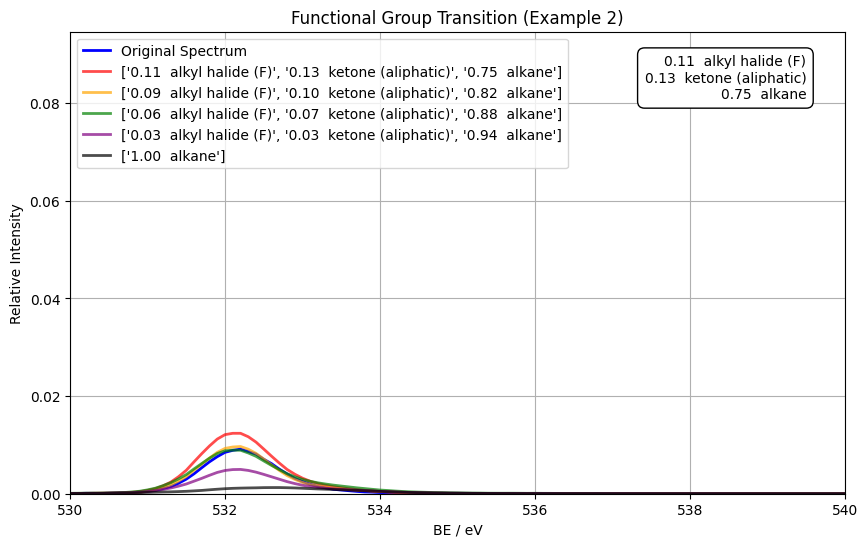

In [19]:
index =2

example_spectra_tensor = torch.tensor(test_spectra[index])
example_label_tensor = torch.tensor(test_labels[index])


# Get test example
with torch.no_grad():
    X_example = example_spectra_tensor.unsqueeze(0).to(device)
    y_example = example_label_tensor.unsqueeze(0).to(device)

# Move to CPU
X_example = X_example.cpu().squeeze()
y_example_list = y_example.cpu().squeeze().tolist()
print(y_example_list)

# Extract components
carbon_count = y_example_list[-1]  # Last element is carbon
functional_groups = np.array(y_example_list[:-1])  # First 39 are FGs

# Get indices of non-zero FGs
fg_indices = np.where(functional_groups > 0)[0]

num_steps = 5
generated_spectra_list = []
y_interpolated_list = []

for step in range(num_steps):
    alpha = step / (num_steps - 1)
    
    # Copy and modify FGs
    y_interpolated = functional_groups.copy()
    
    # Key Fix 1: Decrease FGs by (1-alpha) instead of scaling with alpha
    y_interpolated[fg_indices] *= (1 - alpha)
    
    # Key Fix 2: Calculate new carbon to maintain sum=1
    new_carbon = 1 - y_interpolated.sum()
    y_interpolated = np.append(y_interpolated, new_carbon)
    
    # Generate spectrum
    y_tensor = torch.tensor(y_interpolated, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated_spectrum = model.decode(z, y_tensor).cpu().squeeze()
    
    generated_spectrum = generated_spectrum.cpu().numpy()
    
    generated_spectrum = generated_spectrum/ sum(generated_spectrum)
    print(sum(generated_spectrum))

    generated_spectra_list.append(generated_spectrum)
    y_interpolated_list.append(y_interpolated)


plt.figure(figsize=(10,6))
plt.plot(BE_values, X_example, color="blue", linewidth=2, label="Original Spectrum")
print(f'area of synthetic spectrum: {sum(X_example)}')


colors = ["red", "orange", "green", "purple", "black"]
for i, spectrum in enumerate(generated_spectra_list):

    interpolated_label = y_interpolated_list[i]
    interpolated_label_text = label_converter(interpolated_label, FG_list)

    plt.plot(BE_values, spectrum, 
             linestyle="-", linewidth=2, alpha=0.7, 
             color=colors[i], label=f"{interpolated_label_text}")

plt.xlabel("BE / eV")
plt.ylabel("Relative Intensity")
plt.title(f"Functional Group Transition (Example {index})")
plt.legend()
plt.grid(True)
plt.xlim(530,540)
plt.ylim(0)

# Add label information
label_text = label_converter(y_example_list,FG_list)
plt.text(0.95, 0.95, "\n".join(label_text), 
         ha='right', va='top', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         transform=plt.gca().transAxes)

plt.show()

/tmp/ipykernel_3532212/2465106501.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


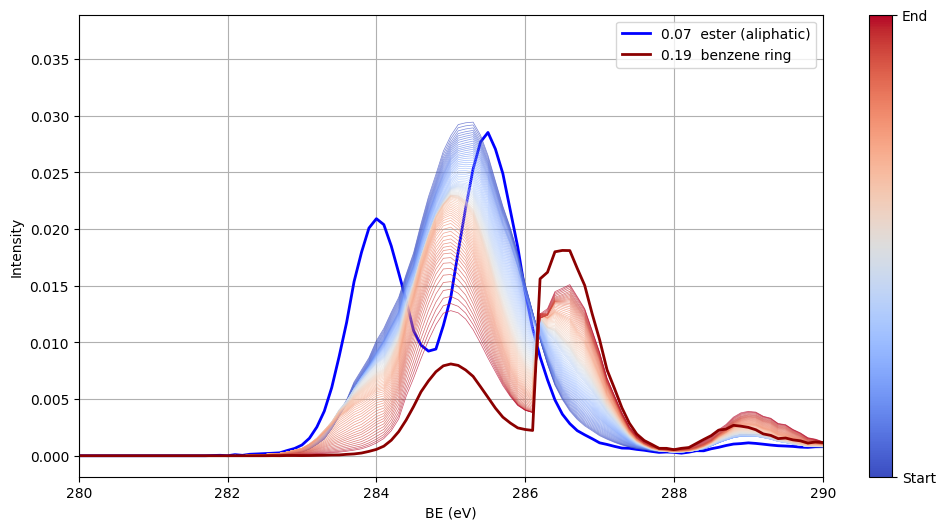

In [38]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps  # modern way

start_index = 22
end_index = 18


# Get two real spectra and their labels
x_start, c_start = torch.tensor(test_spectra[start_index]), torch.tensor(test_labels[start_index])
x_start = x_start.unsqueeze(0).to(device)  # Add batch dimension
c_start = c_start.unsqueeze(0).to(device)

x_end, c_end = torch.tensor(test_spectra[end_index]), torch.tensor(test_labels[end_index])
x_end = x_end.unsqueeze(0).to(device)
c_end = c_end.unsqueeze(0).to(device)

# Encode to get latent parameters
mu_start, logvar_start = model.encode(x_start, c_start)
mu_end, logvar_end = model.encode(x_end, c_end)

# Generate interpolations
num_steps = 80
generated_spectra = []
interp_label_list = []

for alpha in torch.linspace(0, 1, steps=num_steps):
    # Interpolate latent space (using means, not sampled z)
    z_interp = (1 - alpha) * mu_start + alpha * mu_end
    
    # Interpolate conditions (crucial!)
    c_interp = (1 - alpha) * c_start + alpha * c_end

    interp_label_list.append(c_interp)

        
    # Ensure dimensions match
    z_interp = z_interp.to(device)
    c_interp = c_interp.to(device)
    
    # Decode
    with torch.no_grad():
        generated = model.decode(z_interp, c_interp)
    
    # Post-process
    generated = generated.squeeze().cpu().numpy()
    normalised_generated = normalize_spectrum_by_area(generated)
    generated_spectra.append(normalised_generated)


# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
label_1 = label_converter(test_labels[start_index], FG_list)[0]
plt.plot(BE_values, test_spectra[start_index], color="blue", linewidth=2, label= label_1)


cmap = cm.get_cmap('coolwarm')
for i, spec in enumerate(generated_spectra):
    color = cmap(i / (num_steps - 1))  

    interpolated_label = interp_label_list[i].squeeze()
    interpolated_label_np = interpolated_label.cpu().numpy()
    interpolated_label_text = label_converter(interpolated_label_np, FG_list)

    plt.plot(BE_values, spec, color=color, alpha=0.7, linewidth=0.5)

# Create and attach a colorbar to the existing axis
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for older versions of matplotlib
cbar = fig.colorbar(sm, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['Start', 'End'])

label_2 = label_converter(test_labels[end_index], FG_list)[0]
plt.plot(BE_values, test_spectra[end_index], color= 'darkred', linewidth=2, label= label_2)


ax.set_facecolor('white')  # or any color282,291
plt.xlabel("BE (eV)")
plt.ylabel("Intensity")
plt.grid(True)
plt.xlim(280,290)
plt.legend()
plt.show()



In [205]:
test_labels[end_index]

array([0. , 0. , 0.6, 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. ], dtype=float32)

Start ['0.33  benzene ring', '0.27  amine', '0.27  amide', '0.14  alkane']
Finish ['0.07  benzene ring', '0.28  ether (aliphatic)', '0.07  amide', '0.59  alkane']


/tmp/ipykernel_3532212/864400754.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


0.07  benzene ring


'\'\nax.set_facecolor(\'white\')  # or any color282,291\nplt.xlabel("BE (eV)")\nplt.ylabel("Intensity")\nplt.grid(True)\nplt.xlim(282,291)\nplt.legend()\nplt.show()\n'

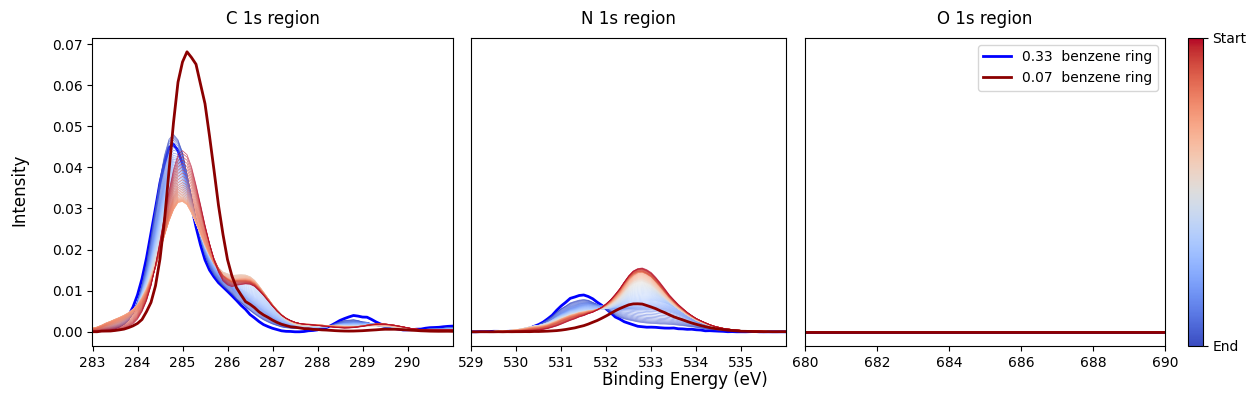

In [39]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps  # modern way

start_index = 14
end_index = 20

print(f'Start {label_converter(test_labels[start_index], FG_list)}')
print(f'Finish {label_converter(test_labels[end_index], FG_list)}')


region1 = (283, 291)   # first interval : C
region2 = (529, 536)   # second interval: N
region3 = (680,690)   # third interval: O


# Get two real spectra and their labels
x_start, c_start = torch.tensor(test_spectra[start_index]), torch.tensor(test_labels[start_index])
x_start = x_start.unsqueeze(0).to(device)  # Add batch dimension
c_start = c_start.unsqueeze(0).to(device)

x_end, c_end = torch.tensor(test_spectra[end_index]), torch.tensor(test_labels[end_index])
x_end = x_end.unsqueeze(0).to(device)
c_end = c_end.unsqueeze(0).to(device)

# Encode to get latent parameters
mu_start, logvar_start = model.encode(x_start, c_start)
mu_end, logvar_end = model.encode(x_end, c_end)

# Generate interpolations
num_steps = 80
generated_spectra = []
interp_label_list = []

for alpha in torch.linspace(0, 1, steps=num_steps):
    # Interpolate latent space (using means, not sampled z)
    z_interp = (1 - alpha) * mu_start + alpha * mu_end
    
    # Interpolate conditions (crucial!)
    c_interp = (1 - alpha) * c_start + alpha * c_end

    interp_label_list.append(c_interp)

        
    # Ensure dimensions match
    z_interp = z_interp.to(device)
    c_interp = c_interp.to(device)
    
    # Decode
    with torch.no_grad():
        generated = model.decode(z_interp, c_interp)
    
    # Post-process
    generated = generated.squeeze().cpu().numpy()
    normalised_generated = normalize_spectrum_by_area(generated)
    generated_spectra.append(normalised_generated)


widths = [r[1]-r[0] for r in (region1, region2, region3)]
fig = plt.figure(figsize=(15, 4))
gs  = fig.add_gridspec(1, 3, width_ratios=widths, wspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)

label_1 = label_converter(test_labels[start_index], FG_list)[0]
ax1.plot(BE_values, test_spectra[start_index], color="blue", linewidth=2, label= label_1)
ax2.plot(BE_values, test_spectra[start_index], color="blue", linewidth=2, label= label_1)
ax3.plot(BE_values, test_spectra[start_index], color="blue", linewidth=2, label= label_1)


cmap = cm.get_cmap('coolwarm')
for i, spec in enumerate(generated_spectra):
    color = cmap(i / (num_steps - 1))  

    interpolated_label = interp_label_list[i].squeeze()
    interpolated_label_np = interpolated_label.cpu().numpy()
    interpolated_label_text = label_converter(interpolated_label_np, FG_list)
    
    ax1.plot(BE_values, spec, color=color, alpha=0.7, lw=0.5)
    ax2.plot(BE_values, spec, color=color, alpha=0.7, lw=0.5)
    ax3.plot(BE_values, spec, color=color, alpha=0.7, lw=0.5)



# Create and attach a colorbar to the existing axis
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for older versions of matplotlib
cbar = fig.colorbar(sm, ax=ax3, ticks=[0, 1])
cbar.set_ticklabels(['End', 'Start'])

label_2 = label_converter(test_labels[end_index], FG_list)[0]
ax1.plot(BE_values, test_spectra[end_index], color= 'darkred', linewidth=2, label= label_2)
ax2.plot(BE_values, test_spectra[end_index], color= 'darkred', linewidth=2, label= label_2)
ax3.plot(BE_values, test_spectra[end_index], color= 'darkred', linewidth=2, label= label_2)



ax1.set_xlim(*region1)
ax2.set_xlim(*region2)
ax3.set_xlim(*region3)
# remove the internal y‐axis labels on the right of ax1
ax1.tick_params(labelright=False)
#   - remove y‑ticks on ax2 & ax3
for ax in (ax2, ax3):
    ax.tick_params(left=False, labelleft=False)

xt = ax1.get_xticks()
ax1.set_xticks(xt[:-1])
xt = ax2.get_xticks()
ax2.set_xticks(xt[:-1])

print(label_2)


# Rebuild the legend
ax3.legend()
ax1.set_title("C 1s region", pad=10, fontsize=12)
ax2.set_title("N 1s region", pad=10, fontsize=12)
ax3.set_title("O 1s region", pad=10, fontsize=12)

fig.supxlabel("Binding Energy (eV)", fontsize=12, x=0.52, y=0.002)
fig.supylabel("Intensity",      fontsize=12, x=0.07, y=0.5)

''''
ax.set_facecolor('white')  # or any color282,291
plt.xlabel("BE (eV)")
plt.ylabel("Intensity")
plt.grid(True)
plt.xlim(282,291)
plt.legend()
plt.show()
'''


In [113]:
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_3532212/3975833667.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")


<function matplotlib.pyplot.show(close=None, block=None)>

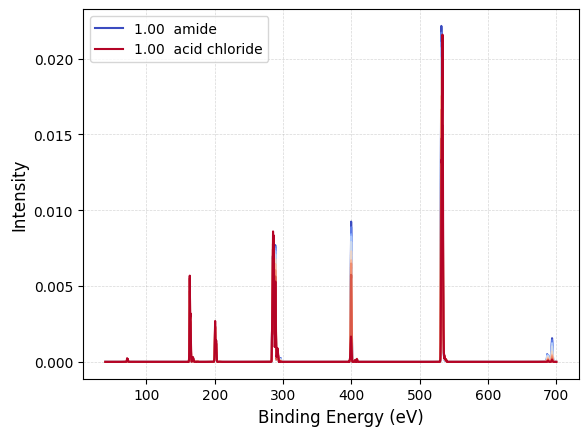

In [45]:
# generate your own spectra:
import matplotlib.cm as cm
import numpy as np

empty_FG_dict = {key: 0 for key in FG_list}
FG_values = np.linspace(0,1,num=10,dtype=np.float32)
fix_carbon = 0




for i,FG_value in enumerate(FG_values):
    #input FG lists with their values
    user_input = {'alkane': fix_carbon, 'amide': ((1.0-fix_carbon)- FG_value), 'acid chloride' :FG_value}
    normalised_user_input = {k: v/sum(user_input.values()) for k, v in user_input.items()}


    for FG, count in normalised_user_input.items():
        if FG in empty_FG_dict:
            empty_FG_dict[FG] = count
        else:
            print(f'invalid FG names: {FG}  ')

    input_list = list(empty_FG_dict.values())


    input_tensor = torch.tensor(input_list)

    #input into model

    z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
    # Get the example from test data
    with torch.no_grad():
        y_input= input_tensor.unsqueeze(0).to(device)  


    # Decode the latent vector to generate spectra
    with torch.no_grad():  # No need to track gradients
        generated_spectra = model.decode(z, y_input)


    generated_spectrum_np = generated_spectra.cpu().squeeze()
    normalised_generated_spectrum = normalize_spectrum_by_area(generated_spectrum_np)


    cmap = cm.get_cmap("coolwarm")
    num_spectra = len(FG_values)
    color = cmap(i / (num_spectra - 1))

    if FG_value in [0,1]:
        label_text = label_converter(input_list,FG_list)
        plt.plot(BE_values, normalised_generated_spectrum, color = color, label = label_text)

    else:
        plt.plot(BE_values, normalised_generated_spectrum, color = color)
   

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlabel("Binding Energy (eV)", fontsize=12, x=0.52, y=0.002)
plt.ylabel("Intensity",      fontsize=12, x=0.07, y=0.5)
plt.xlim()
plt.ylim()
plt.legend()
plt.show
#print result

In [41]:
print(FG_list)

['alkene', 'alkyne', 'benzene ring', 'naphthalene', 'amine', 'alcohol (aromatic)', 'alcohol (aliphatic)', 'ether (aromatic)', 'ether (aliphatic)', 'alkyl halide (F)', 'alkyl halide (Cl)', 'alkyl halide (Br)', 'alkyl halide (I)', 'thiol', 'aldehyde', 'ketone (aromatic)', 'ketone (aliphatic)', 'ester (aromatic)', 'ester (aliphatic)', 'carboxylic acid', 'amide', 'nitrite', 'nitrate', 'nitrile', 'epoxide', 'imide', 'acid chloride', 'anhydride', 'nitro (aromatic)', 'sulfide', 'sulfone', 'sulfonate', 'azide', 'chlorobenzene', 'bromobenzene', 'siloxane', 'phosphazene', 'phenoxy', 'pyridine', 'alkane']


In [50]:
# generate your own spectra:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors

empty_FG_dict = {key: 0 for key in FG_list}
FG_values = np.linspace(0,1,num=100,dtype=np.float32)
fix_carbon = 0

region1 = (200, 203)   # Si/S region (now first)
region2 = (283, 290)   # C 1s
region3 = (399, 402)   # N 1s
region4 = (530, 536)   # O 1s




regions = [region1, region2, region3, region4]
widths = [r[1] - r[0] for r in regions]

fig = plt.figure(figsize=(12, 4))
gs  = fig.add_gridspec(1, 4, width_ratios=widths, wspace=0.05)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)
ax4 = fig.add_subplot(gs[3], sharey=ax1)

for i,FG_value in enumerate(FG_values):
    #input FG lists with their values
    user_input = {'amide': ((1.0-fix_carbon)- FG_value), 'carboxylic acid' :FG_value}
    normalised_user_input = {k: v/sum(user_input.values()) for k, v in user_input.items()}


    for FG, count in normalised_user_input.items():
        if FG in empty_FG_dict:
            empty_FG_dict[FG] = count
        else:
            print(f'invalid FG names: {FG}  ')

    input_list = list(empty_FG_dict.values())


    input_tensor = torch.tensor(input_list)

    #input into model

    z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector
    # Get the example from test data
    with torch.no_grad():
        y_input= input_tensor.unsqueeze(0).to(device)  


    # Decode the latent vector to generate spectra
    with torch.no_grad():  # No need to track gradients
        generated_spectra = model.decode(z, y_input)


    generated_spectrum_np = generated_spectra.cpu().squeeze()
    normalised_generated_spectrum = normalize_spectrum_by_area(generated_spectrum_np)


    cmap = cm.get_cmap("coolwarm")
    num_spectra = len(FG_values)
    color = cmap(i / (num_spectra - 1))

    ax1.plot(BE_values, normalised_generated_spectrum, color = color, alpha=0.9, lw=0.5)
    ax2.plot(BE_values, normalised_generated_spectrum, color = color, alpha=0.9, lw=0.5)
    ax3.plot(BE_values, normalised_generated_spectrum, color = color, alpha=0.9, lw=0.5)
    ax4.plot(BE_values, normalised_generated_spectrum, color = color, alpha=0.9, lw=0.5)
   


ax1.set_xlim(*region1)
ax2.set_xlim(*region2)
ax3.set_xlim(*region3)
ax4.set_xlim(*region4)
# remove the internal y‐axis labels on the right of ax1
ax1.tick_params(labelright=False)
#   - remove y‑ticks on ax2 & ax3
for ax in (ax2, ax3, ax4):
    ax.tick_params(left=False, labelleft=False)

xt = ax1.get_xticks()
ax1.set_xticks(xt[:-1])
xt = ax2.get_xticks()
ax2.set_xticks(xt[:-1])
xt = ax3.get_xticks()
ax3.set_xticks(xt[:-1])


# Get current handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Reverse their order
handles = handles[::-1]
labels  = labels[::-1]

# Add subtle gridlines to all axes
for ax in (ax1, ax2, ax3, ax4):
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Rebuild the legend
#ax4.legend(handles, labels, loc='upper right')
ax1.set_title("Cl 2p region", pad=10, fontsize=12)
ax2.set_title("C 1s region", pad=10, fontsize=12)
ax3.set_title("N 1s region", pad=10, fontsize=12)
ax4.set_title("O 1s region", pad=10, fontsize=12)

fig.supxlabel("Binding Energy (eV)", fontsize=12, x=0.52, y=0.002)
fig.supylabel("Intensity",      fontsize=12, x=0.06, y=0.5)

# Create and attach a colorbar to the existing axis
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for older versions of matplotlib
cbar = fig.colorbar(sm, ax=ax4, ticks=[0,0.5, 1])
cbar.set_ticklabels(['1.0: amide', '0.5', '1.0: Acid Chloride'])


ValueError: Expected the given number of width ratios to match the number of columns of the grid

<Figure size 1200x400 with 0 Axes>

/tmp/ipykernel_3532212/2146756416.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")
/tmp/ipykernel_3532212/2146756416.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0.05, 0.98, 0.95]) # Adjust rect to prevent labels overlapping titles/colorbar


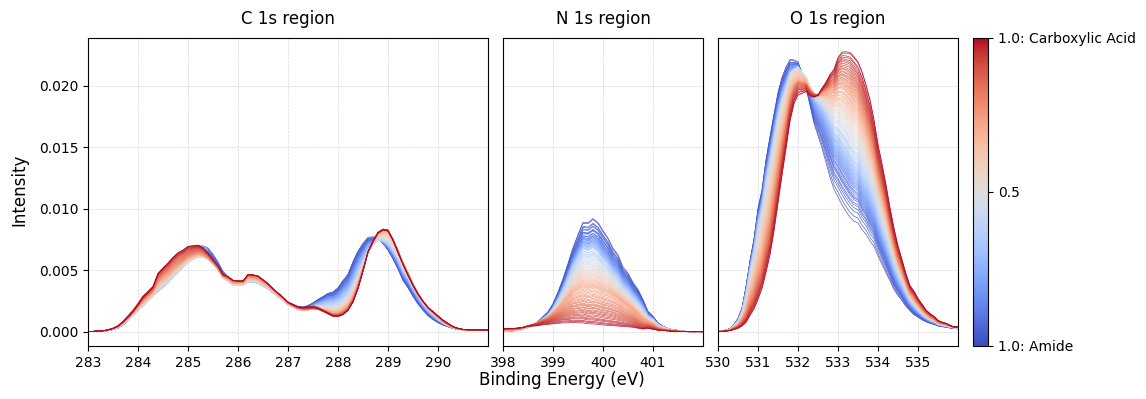

In [54]:
import matplotlib.pyplot as plt # Make sure matplotlib is imported
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors
import torch # Assuming torch is used elsewhere for model/tensors

# --- Your Setup (assuming these are defined elsewhere) ---
# FG_list = ['amide', 'carboxylic acid'] # Example
# latent_dim = ... # Example
# device = torch.device(...) # Example
# model = ... # Your loaded model
# BE_values = ... # Your Binding Energy array
# def normalize_spectrum_by_area(spec_np): # Your normalization function
#    # ... (implementation from previous example) ...
#    spec_np = np.maximum(spec_np, 0)
#    total_area = np.sum(spec_np)
#    if total_area > 1e-9:
#        return spec_np / total_area
#    else:
#        return spec_np # Or np.zeros_like(spec_np)
# --- End Setup ---


# --- Configuration: Define all possible regions and select which to show ---
all_regions = {
    "region1": {"range": (200, 203), "title": "Si/S region"}, # Si/S region (now first) - Not shown
    "region2": {"range": (283, 291), "title": "C 1s region"},   # C 1s
    "region3": {"range": (398, 402), "title": "N 1s region"},   # N 1s
    "region4": {"range": (530, 536), "title": "O 1s region"}    # O 1s
}

# ----> TOGGLE HERE: List the keys of the regions you want to display <----
regions_to_display_keys = ["region2", "region3", "region4"]

# Filter the regions based on the keys selected
regions_data = [all_regions[key] for key in regions_to_display_keys]
regions = [data["range"] for data in regions_data]
titles = [data["title"] for data in regions_data]
widths = [r[1] - r[0] for r in regions]
num_regions_to_display = len(regions_to_display_keys)
# --------------------------------------------------------------------------


# --- Figure Setup based on selected regions ---
fig = plt.figure(figsize=(4 * num_regions_to_display, 4)) # Adjust figsize dynamically
gs = fig.add_gridspec(1, num_regions_to_display, width_ratios=widths, wspace=0.05)

axes = []
for i in range(num_regions_to_display):
    share_y_axis = axes[0] if i > 0 else None # Share Y with the first axis (if it exists)
    ax = fig.add_subplot(gs[i], sharey=share_y_axis)
    axes.append(ax)
# -----------------------------------------------

# --- Data Generation and Plotting Loop ---
empty_FG_dict = {key: 0 for key in FG_list} # Ensure FG_list is defined
FG_values = np.linspace(0, 1, num=100, dtype=np.float32)
fix_carbon = 0 # Assuming this is defined

cmap = cm.get_cmap("coolwarm")
num_spectra = len(FG_values)

for i, FG_value in enumerate(FG_values):
    # input FG lists with their values
    # Ensure 'amide' and 'carboxylic acid' are in your FG_list
    user_input = {'amide': ((1.0 - fix_carbon) - FG_value), 'carboxylic acid': FG_value}

    # Basic check for division by zero if both values could be zero
    total_input = sum(user_input.values())
    if total_input > 1e-9:
        normalised_user_input = {k: v / total_input for k, v in user_input.items()}
    else:
        normalised_user_input = user_input # Handle case where input sum is zero

    # Reset empty_FG_dict for each iteration before filling
    current_empty_FG_dict = {key: 0 for key in FG_list}
    for FG, count in normalised_user_input.items():
        if FG in current_empty_FG_dict:
            current_empty_FG_dict[FG] = count
        else:
            print(f'invalid FG name: {FG}') # Corrected typo

    input_list = list(current_empty_FG_dict.values())
    input_tensor = torch.tensor(input_list, dtype=torch.float32) # Ensure correct dtype

    # input into model
    z = torch.randn(1, latent_dim).to(device) # Sample a random latent vector
    with torch.no_grad():
        y_input = input_tensor.unsqueeze(0).to(device)

    # Decode the latent vector to generate spectra
    with torch.no_grad(): # No need to track gradients
        generated_spectra = model.decode(z, y_input)

    # Ensure BE_values is defined and has the correct shape
    # generated_spectra likely has shape [1, num_BE_points], squeeze removes the batch dim
    generated_spectrum_np = generated_spectra.cpu().squeeze().detach().numpy()

    # Normalize the NumPy array spectrum
    # Make sure BE_values and generated_spectrum_np align
    normalised_generated_spectrum = normalize_spectrum_by_area(generated_spectrum_np)

    color = cmap(i / (num_spectra - 1))

    # Plot on all *active* axes
    for ax in axes:
        ax.plot(BE_values, normalised_generated_spectrum, color=color, alpha=0.9, lw=0.5)
# --- End Plotting Loop ---


# --- Axis Formatting ---
for i, ax in enumerate(axes):
    # Set X limits and title for each active axis
    ax.set_xlim(*regions[i])
    ax.set_title(titles[i], pad=10, fontsize=12)

    # Handle Y-axis ticks and labels
    if i > 0: # If not the first axis
        ax.tick_params(left=False, labelleft=False)
    else: # If the first axis
        ax.tick_params(labelright=False) # Optional: remove right ticks if needed

    # Remove the last x-tick label for visual spacing (optional)
    xt = ax.get_xticks()
    if len(xt) > 1: # Avoid error if there's only one tick
      ax.set_xticks(xt[:-1])

    # Add subtle gridlines to all active axes
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.5)
# -----------------------


# --- Legend and Colorbar ---
# Get current handles and labels (from the first axis, as all have the same lines)
# handles, labels = axes[0].get_legend_handles_labels()
# Reverse their order if needed
# handles = handles[::-1]
# labels  = labels[::-1]
# Rebuild the legend (optional, currently commented out in your original code)
# axes[-1].legend(handles, labels, loc='upper right') # Attach legend to the last axis


# Create and attach a colorbar to the last existing axis
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Required for older versions of matplotlib
cbar = fig.colorbar(sm, ax=axes[-1], ticks=[0, 0.5, 1]) # Attach to the last *active* axis
cbar.set_ticklabels(['1.0: Amide', '0.5', '1.0: Carboxylic Acid']) # Make sure labels match FG_values range
# -------------------------


# --- Super Labels ---
fig.supxlabel("Binding Energy (eV)", fontsize=12, x=0.52, y=0.002) # Adjust x/y as needed
fig.supylabel("Intensity", fontsize=12, x=0.06, y=0.5) # Adjust x/y as needed
# -------------------

plt.tight_layout(rect=[0.07, 0.05, 0.98, 0.95]) # Adjust rect to prevent labels overlapping titles/colorbar
plt.show()

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load your data
test_spectra = np.load(test_spectra_dir)
unormalised_labels = np.load(test_labels_dir)
test_labels = np.array([label_normaliser(i) for i in unormalised_labels])  # Normalized labels

# Convert to PyTorch tensors
test_spectra_tensor = torch.from_numpy(test_spectra).float()
test_labels_tensor = torch.from_numpy(test_labels).float()

# Create dataset and dataloader
test_d = TensorDataset(test_spectra_tensor, test_labels_tensor)
test_loader = DataLoader(test_d, batch_size=128, shuffle=False)

# Collect latent vectors
latent_vectors = []
model.eval()  # Set model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        mu, log_var = model.encode(X, y)  # Get latent vectors
        latent_vectors.append(mu.cpu().numpy())

latent_vectors = np.vstack(latent_vectors)

# Get sp3 counts from ORIGINAL labels (assuming last column contains sp3 counts)
sp3_counts = unormalised_labels[:, -1]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Plot
plt.figure(figsize=(12, 8))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                c=sp3_counts, 
                cmap='viridis', 
                alpha=0.7,
                s=15)
plt.colorbar(sc, label='sp3 Carbon Count')
plt.title('Latent Space Colored by sp3 Carbon Content')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

## Plotting broken data

In [ ]:

labels_dir = Path('../data/synthetic_data_final/synthetic_labels')
all_labels = [labels_dir / file for file in os.listdir(labels_dir)]

#extracting synthetic label data and converting to tensor
all_labels.sort(key=lambda x: int(x.stem.split('_')[1]))
label_list = []
for label_path in all_labels:
    label_df = pd.read_csv(label_path)
    # Normalize the label values so they sum to one
    normalised_label = label_df / label_df.sum()  # Divide the DataFrame by the sum of its values 
    label_list.append(normalised_label)
    

print(label_list[0])

      Labels
0   0.000000
1   0.000000
2   0.305080
3   0.000000
4   0.203387
5   0.000000
6   0.000000
7   0.000000
8   0.143619
9   0.000000
10  0.000000
11  0.000000
12  0.000000
13  0.000000
14  0.000000
15  0.000000
16  0.000000
17  0.000000
18  0.000000
19  0.000000
20  0.000000
21  0.000000
22  0.000000
23  0.000000
24  0.000000
25  0.000000
26  0.000000
27  0.000000
28  0.000000
29  0.000000
30  0.000000
31  0.000000
32  0.000000
33  0.000000
34  0.000000
35  0.000000
36  0.000000
37  0.000000
38  0.000000
39  0.347914


In [ ]:


# 1. Pre-allocate memory and store all values for all classes before plotting
all_values = {class_name: [] for class_name in FG_list}  # Use a dictionary

for label_df in label_list:
    for i, class_name in enumerate(FG_list):
        if i in label_df.index:
            value = label_df.loc[i].item()
            if value > 0:  # Only include values greater than 0
                all_values[class_name].append(value)



AttributeError: 'numpy.ndarray' object has no attribute 'index'

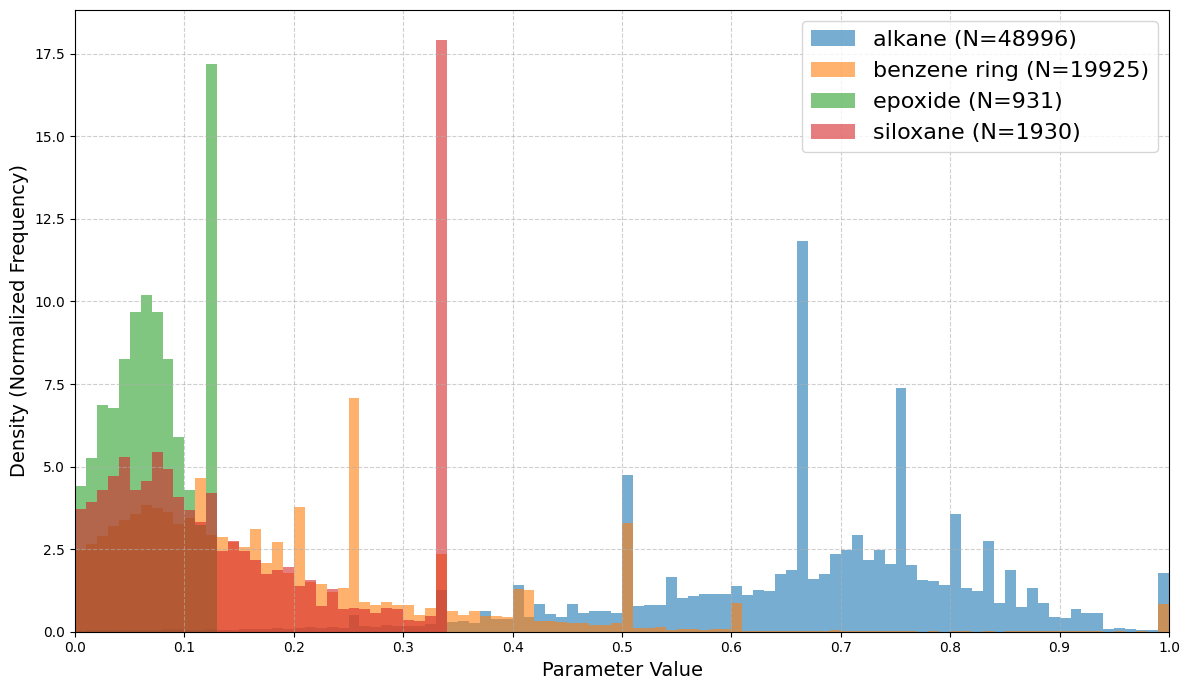

In [ ]:
FGs_of_interest = ['alkane', 'benzene ring', 'epoxide', 'siloxane']

num_colors = len(FGs_of_interest)
colors = plt.cm.tab10.colors[:num_colors]


# Define number of bins
num_bins = 100
# Define the range and bins
bin_edges = np.linspace(0, 1, num_bins + 1)

# --- Corrected Plotting Code ---
plt.figure(figsize=(12, 7)) # Create a single figure

# Loop through each functional group of interest
for i, class_name in enumerate(FGs_of_interest):
    # Check if the class_name exists in the data and handle potential KeyError
    if class_name in all_values:
        values = all_values[class_name]
        # Ensure values is a numpy array for consistency
        values = np.asarray(values)

        # Check if there is data to plot for this group
        if values.size > 0:
            # Plot the normalized histogram using density=True
            # density=True ensures the area under the histogram integrates to 1
            plt.hist(values,
                     bins=bin_edges,
                     density=True, # Use density=True for normalization
                     alpha=0.6,    # Slightly increased alpha for better visibility
                     color=colors[i],
                     label=f"{class_name} (N={len(values)})") # Add count to label
        else:
            # Optional: Add a label for empty groups if desired, but don't plot histogram
             print(f"No data for {class_name}, skipping histogram.")
             # If you still want it in the legend even if empty:
             # plt.plot([], [], color=colors[i], label=f"{class_name} (N=0)") # Plot empty line for legend entry
    else:
        print(f"Class name '{class_name}' not found in all_values dictionary.")


# Add plot titles and labels
plt.xlabel('Parameter Value', fontsize = 14)
plt.ylabel('Density (Normalized Frequency)', fontsize = 14) # Y-axis is density when density=True

# --- Set X-axis Ticks ---
# Generate ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)
plt.xticks(x_ticks)

# --- Add Legend ---
# Place legend inside the plot area in the upper left corner
plt.legend(loc='upper right', fontsize = 16) # Changed location

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Set x-axis limits (redundant with xticks but good practice)
plt.xlim(0, 1)

# Adjust layout to prevent labels from overlapping (may not be needed with legend inside)
plt.tight_layout() # Removed rect argument

# Show the plot
plt.show()
